# Imports

In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import umap
import seaborn as sns
import subprocess

In [36]:
# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")

# Utils

In [37]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # For GPU determinism
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # Slower, but deterministic
    torch.backends.cudnn.benchmark = False     # Disable performance optimization

def create_dir_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"[INFO] Created directory: {path}")


def save_data(features, scores, labels, path):
    data = np.concatenate((features.detach().cpu().numpy(), scores.detach().cpu().numpy()), axis=1)
    df = pd.DataFrame(data)
    df['label'] = labels.detach().cpu().numpy()
    df.to_csv(path, index=False)
    print(f"[INFO] Data saved to {path}")

def parse_digits(task_str):
    ranges = task_str.split(",")
    digits = []
    for r in ranges:
        if "-" in r:
            start, end = map(int, r.split("-"))
            digits.extend(range(start, end + 1))
        else:
            digits.append(int(r))
    return sorted(set(digits))

In [38]:
def load_mnist_task(digits, num_samples=None, is_train=True):
    """
    Load a MNIST dataset filtered by digits, optionally sample and update buffer.
    
    Args:
        digits: List of digits to include (e.g., [0, 1, 2, 3, 4])
        num_samples: If given, randomly sample this many from the filtered set
        buffer: A list (or set) to be updated with indices (global to full dataset)
        buffer_update_size: Number of samples from current digits to add to buffer
        is_train: Whether to load training or test data

    Returns:
        filtered_dataset: torch.utils.data.Subset of MNIST
        selected_indices: list of selected indices (relative to full dataset)
    """
    transform = transforms.ToTensor()
    mnist = datasets.MNIST("../data", train=is_train, download=True, transform=transform)
    # mnist.targets = torch.tensor(mnist.targets, dtype=torch.long)

    # Filter by digits
    filtered_indices = [i for i, t in enumerate(mnist.targets) if t in digits]

    # Optional sampling
    if is_train and num_samples is not None and num_samples < len(filtered_indices):
        selected_indices = random.sample(filtered_indices, num_samples)
    else:
        selected_indices = filtered_indices
    
    # Get labels for selected indices
    selected_labels = mnist.targets[selected_indices]
    dataset = Subset(mnist, selected_indices)

    return dataset, selected_indices, selected_labels

# Global Config

In [39]:
# Global
GP_Ylogspace = "FALSE" #NOTE: For GP training, set to "TRUE" or "FALSE"
GP_doubleSoftmax = True
GP_package = 'laGP'

seed = 42
n_tr = 1500
n_ts = 1000
n_octr = 50
n_indcpts = 1000
n_genpts = 500
f_size = 64
root_folder = f"AE{GP_package}_tr{n_tr}ts{n_ts}octr{n_octr}_indcpts{n_indcpts}_f{f_size}_genpts{n_genpts}"
if GP_doubleSoftmax:
    root_folder += "_doubleSoftmax"
if GP_Ylogspace.upper() == "TRUE":
    root_folder += "_Ylogspace"


# each task training config
train_batch_size = 128
test_batch_size = 128
epochs = 30


num_tasks = 6
global_task_labels = ["Task 0: 0-4", "Task 1: 5", "Task 2: 6", "Task 3: 7", "Task 4: 8", "Task 5: 9"]
tasks_epochs_accuracy = [[] for _ in range(num_tasks)] # list of lists (rows: tasks, cols: epochs)
tasks_epochs_accuracy_train = [[] for _ in range(num_tasks)]

global_num_epochs = 0
global_tsloaders = []
global_trloaders = []

# AutoEncoder

In [40]:
class AEClassifier(nn.Module):
    def __init__(self, f_size=32, num_classes=10):
        super(AEClassifier, self).__init__()
        self.f_size = f_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, f_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(f_size, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(f_size),
            nn.Linear(f_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        logits = self.classifier(z)
        return x_recon, logits

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def predict(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        out = F.softmax(logits, dim=1) # can add temperature scaling
        if GP_doubleSoftmax:
            out = F.softmax(out, dim=1) #Double softmax
        return out


In [41]:
# --- Accuracy helper ---
def accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

# --- Training function ---
def train(model, trloader, task_id, tsloaders, epochs=20, lr=1e-3):
    model.to(device)
    recon_loss = nn.MSELoss()
    class_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print("Training started...")
    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for data, labels in trloader:
            data, labels = data.to(device), labels.to(device)
            recon, logits = model(data)

            loss_r = recon_loss(recon, data.view(-1, 28*28))
            loss_c = class_loss(logits, labels)
            loss = loss_r + loss_c

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(logits, labels)

        train_loss /= len(trloader)
        train_acc /= len(trloader)
        train_acc = 100 * train_acc
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # per epoch evaluation
        for task in range(num_tasks):
            if task <= task_id:
                tasks_epochs_accuracy_train[task].append(train_acc)
                test_acc = test(model, tsloaders[task])
                tasks_epochs_accuracy[task].append(test_acc)
            else:
                tasks_epochs_accuracy_train[task].append(np.nan)
                tasks_epochs_accuracy[task].append(np.nan)
    print("Training complete.\n")

# --- Testing function ---
def test(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            logits = model.predict(data)
            test_acc += accuracy(logits, labels)
    test_acc /= len(test_loader)
    test_acc = 100 * test_acc
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc

# --- Encoder and Labels ---
def get_f_and_labels(model, data_loader):
    model.eval()
    features, scores, labels = [], [], []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            f = model.encode(data)
            out = model.predict(data)

            features.append(f.cpu())
            scores.append(out.cpu())
            labels.append(label.cpu())

    features = torch.cat(features, dim=0)
    scores = torch.cat(scores, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, scores, labels

def show_reconstructions_by_label(model, dataloader, labels_to_show=range(10)):
    model.eval()
    label_to_img = {}

    for imgs, lbls in dataloader:
        for img, lbl in zip(imgs, lbls):
            lbl_int = int(lbl)
            if lbl_int in labels_to_show and lbl_int not in label_to_img:
                label_to_img[lbl_int] = img
            if len(label_to_img) == len(labels_to_show):
                break
        if len(label_to_img) == len(labels_to_show):
            break

   
    missing = set(labels_to_show) - set(label_to_img.keys())
    if missing:
        print(f"[WARNING] Could not find images for labels: {missing}")

    if not label_to_img:
        print("[ERROR] No images collected for requested labels.")
        return

    sorted_labels = sorted(label_to_img.keys())
    imgs = torch.stack([label_to_img[lbl] for lbl in sorted_labels]).to(device)

    with torch.no_grad():
        recon, _ = model(imgs)

    imgs = imgs.cpu().numpy()
    recon = recon.view(-1, 1, 28, 28).cpu().numpy()

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, len(sorted_labels), figsize=(len(sorted_labels) * 1.5, 3))
    for i, lbl in enumerate(sorted_labels):
        axes[0, i].imshow(imgs[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f"Label: {lbl}")
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')

    plt.suptitle("Top: Original | Bottom: Reconstruction (by label)")
    plt.tight_layout()
    plt.show()


In [42]:
# UMAP visualization
def umap_train_features_visualization(train_features, train_scores, train_labels, task):
    def plot_umap(data, labels, title_suffix):
        reducer = umap.UMAP(n_components=2, random_state=seed)
        embedding = reducer.fit_transform(data.cpu().numpy())
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='Spectral', s=40, alpha=0.8)
        plt.title(f"UMAP Projection of {title_suffix} (Task {task})")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    plot_umap(train_features, train_labels, "Train Features")
    plot_umap(train_scores, train_labels, "Train Logits")

# Task 0 (digit 0-4)

In [43]:
task = '0-4'
train_batch_size = 128
test_batch_size = 128
epochs = 20

# Output dirs
parent_dir = os.getcwd()
parent_dir = os.path.join(parent_dir, root_folder)
task_dir = os.path.join(parent_dir, f'task{task}')
out_dir = os.path.join(task_dir, f'out/f{f_size}_task{task}')
model_dir = os.path.join(task_dir, f'model/f{f_size}_task{task}')
create_dir_if_not_exists(out_dir)
create_dir_if_not_exists(model_dir)

[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4/out/f64_task0-4
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4/model/f64_task0-4


Train set size:  30596
Test set size:  5139
Train class counts: [5923 6742 5958 6131 5842]
Test class counts: [ 980 1135 1032 1010  982]
Training started...
Epoch [1/20], Loss: 0.3025, Accuracy: 94.74%
Test Accuracy: 98.29%
Epoch [2/20], Loss: 0.0914, Accuracy: 98.53%
Test Accuracy: 98.88%
Epoch [3/20], Loss: 0.0642, Accuracy: 99.09%
Test Accuracy: 99.07%
Epoch [4/20], Loss: 0.0580, Accuracy: 99.19%
Test Accuracy: 99.12%
Epoch [5/20], Loss: 0.0510, Accuracy: 99.37%
Test Accuracy: 99.29%
Epoch [6/20], Loss: 0.0450, Accuracy: 99.37%
Test Accuracy: 99.22%
Epoch [7/20], Loss: 0.0345, Accuracy: 99.61%
Test Accuracy: 99.22%
Epoch [8/20], Loss: 0.0315, Accuracy: 99.65%
Test Accuracy: 99.39%
Epoch [9/20], Loss: 0.0349, Accuracy: 99.40%
Test Accuracy: 98.80%
Epoch [10/20], Loss: 0.0441, Accuracy: 99.32%
Test Accuracy: 99.26%
Epoch [11/20], Loss: 0.0260, Accuracy: 99.76%
Test Accuracy: 99.13%
Epoch [12/20], Loss: 0.0253, Accuracy: 99.76%
Test Accuracy: 99.12%
Epoch [13/20], Loss: 0.0217, Accurac

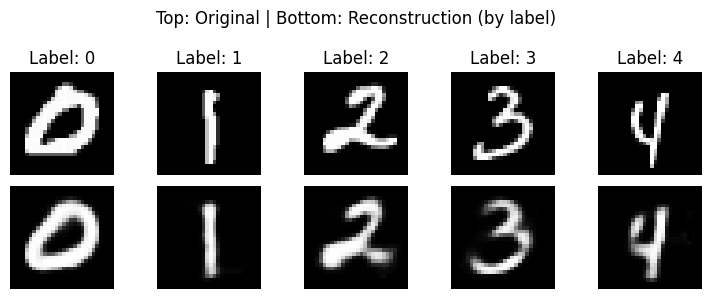

[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4/out/f64_task0-4/train_sftmx.csv
[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4/out/f64_task0-4/test_sftmx.csv

[INFO] END


In [44]:
# Data
set_seed(seed)
digits = parse_digits(task)


train_set, _, train_labels = load_mnist_task(digits, is_train=True)
test_set, _, test_labels = load_mnist_task(digits, is_train=False)

print("Train set size: ", len(train_set))
print("Test set size: ", len(test_set))

print("Train class counts:", np.bincount(train_labels.numpy()))
print("Test class counts:", np.bincount(test_labels.numpy()))

trloader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
tsloader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

global_trloaders.append(trloader)
global_tsloaders.append(tsloader)

# Train MNIST
model = AEClassifier(f_size=f_size).to(device)
train(model, trloader, epochs=epochs, task_id=0, tsloaders=global_tsloaders)
torch.save(model.state_dict(), os.path.join(model_dir, f"MNIST_f{f_size}_task_{task}_net.pt"))

# 
train_features, train_scores, train_labels = get_f_and_labels(model, trloader)
test_features, test_scores, test_labels = get_f_and_labels(model, tsloader)

print(f"Train features: {train_features.shape}, labels: {train_labels.shape}")
print(f"Test features: {test_features.shape}, labels: {test_labels.shape}")

train_acc = accuracy(train_scores, train_labels)
test_acc = accuracy(test_scores, test_labels)
print(f"Final Train Accuracy: {train_acc*100:.2f}%")
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# show reconstructions
show_reconstructions_by_label(model, trloader, labels_to_show=digits)

# flatten featurens
save_data(train_features, train_scores, train_labels, os.path.join(out_dir, 'train_sftmx.csv'))
save_data(test_features, test_scores, test_labels, os.path.join(out_dir, 'test_sftmx.csv'))

global_num_epochs += epochs
print("\n[INFO] END")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[98.28506097560977, 98.88077669027375, 99.06631097560977, 99.1234756097561, 99.29496951219512, 99.21875, 99.21875, 99.39024390243902, 98.79954268292683, 99.25685975609755, 99.1284901049079, 99.1234756097561, 99.14253048780488, 99.0282012195122, 99.1234756097561, 99.29496951219512, 99.27591463414635, 99.37118902439023, 99.16158536585365, 99.25685975609755]


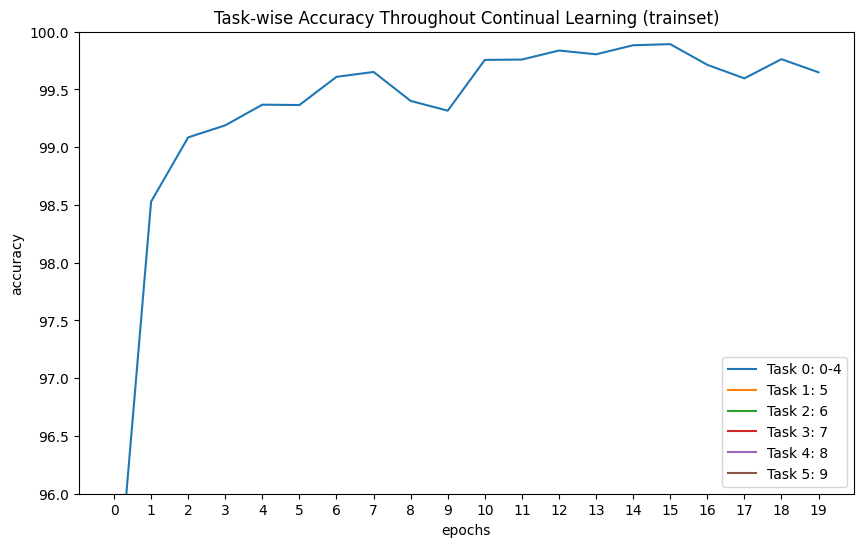

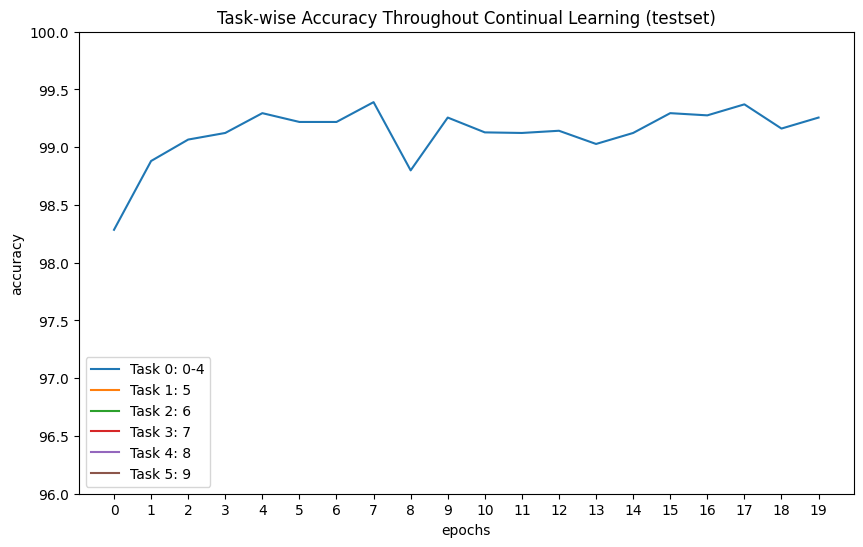

In [45]:
x = np.arange(global_num_epochs)
print(x)
print(tasks_epochs_accuracy[0])

x = np.arange(global_num_epochs)

# Train set
plt.figure(figsize=(10, 6))
for task_id, accs in enumerate(tasks_epochs_accuracy_train):
    plt.plot(x, accs, label=global_task_labels[task_id])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Task-wise Accuracy Throughout Continual Learning (trainset)")
plt.legend()
plt.ylim(96, 100)
plt.xticks(np.arange(0, global_num_epochs, 1))
plt.show()

# Test set
plt.figure(figsize=(10, 6))
for task_id, accs in enumerate(tasks_epochs_accuracy):
    plt.plot(x, accs, label=global_task_labels[task_id])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Task-wise Accuracy Throughout Continual Learning (testset)")
plt.legend()
plt.ylim(96, 100)
plt.xticks(np.arange(0, global_num_epochs, 1))
plt.show()

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


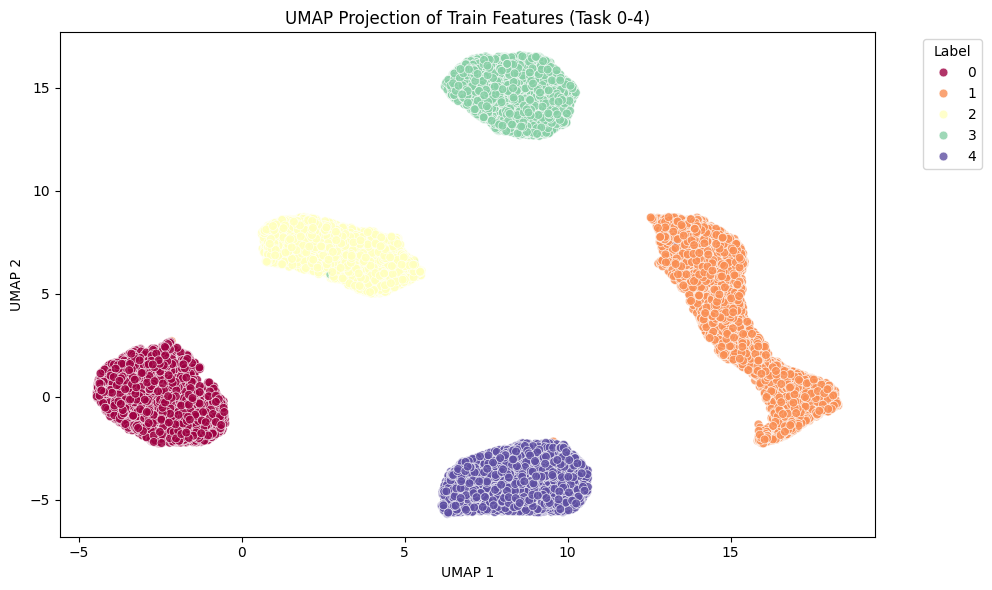

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


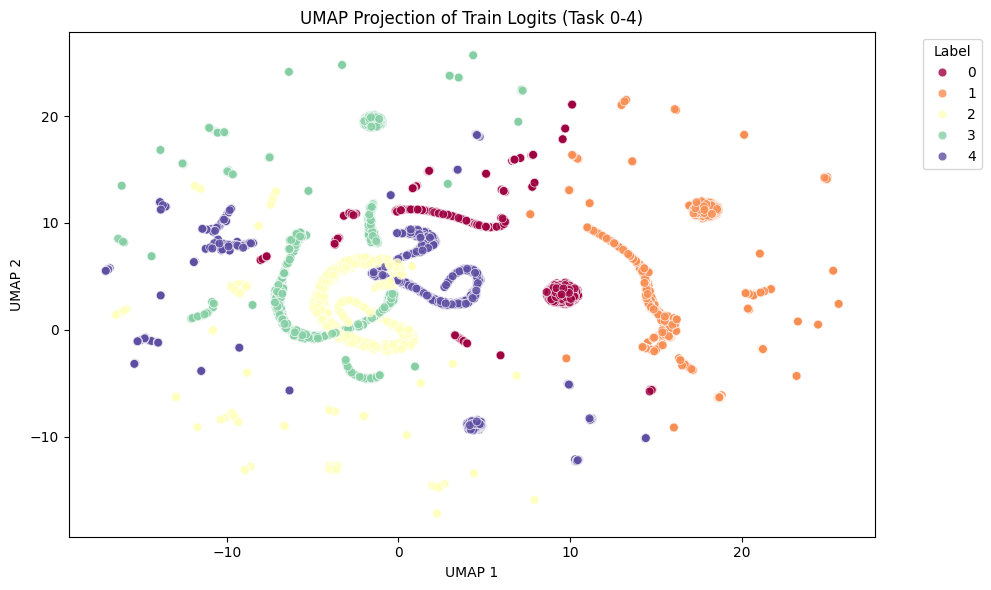

In [46]:
umap_train_features_visualization(train_features, train_scores, train_labels, task)

In [47]:
df = pd.read_csv(os.path.join(out_dir, 'train_sftmx.csv'))
filtered_df = pd.DataFrame()

for i in range(1, 11):
    class_group = df[df['label'] == i-1]
    print(f"Class {i-1} size:", len(class_group))
    column_idx = f_size+i-1
    mean = class_group.iloc[:, column_idx].mean()
   
    lower_bound = class_group.iloc[:, column_idx].quantile(0.05)
    upper_bound = class_group.iloc[:, column_idx].quantile(0.95)
    print(f"  -> mean={mean:.5f}, lower={lower_bound:.5f}, upper={upper_bound:.5f}")

    filtered_class_group = class_group[
        (class_group.iloc[:, column_idx] >= lower_bound) &
        (class_group.iloc[:, column_idx] <= upper_bound)
    ]
    print(f"  -> kept: {len(filtered_class_group)} rows")
    save_path= os.path.join(out_dir, 'filtered_train_sftmx.csv')
    filtered_df = pd.concat([filtered_df, filtered_class_group])

filtered_df.to_csv(save_path, index=False)
print("Filtered Training Data")

Class 0 size: 5923
  -> mean=0.23191, lower=0.23196, upper=0.23197
  -> kept: 5626 rows
Class 1 size: 6742
  -> mean=0.23189, lower=0.23196, upper=0.23197
  -> kept: 6404 rows
Class 2 size: 5958
  -> mean=0.23169, lower=0.23183, upper=0.23197
  -> kept: 5660 rows
Class 3 size: 6131
  -> mean=0.23103, lower=0.23139, upper=0.23197
  -> kept: 5824 rows
Class 4 size: 5842
  -> mean=0.23176, lower=0.23182, upper=0.23197
  -> kept: 5549 rows
Class 5 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 6 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 7 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 8 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 9 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Filtered Training Data


In [48]:
train_data_file = os.path.join(out_dir, 'filtered_train_sftmx.csv')
test_data_file = os.path.join(out_dir, 'test_sftmx.csv')

In [49]:

cmd = [
    "/usr/local/bin/Rscript",
    "./GP_train.R",
    "-f", str(f_size),
    "--n_tr", str(n_tr),
    "--n_ts", str(n_ts),
    "--n_octr", str(n_octr),
    "--n_indcpts", str(n_indcpts),
    "--data_tr", train_data_file,
    "--data_ts", test_data_file,
    "--directory", task_dir,
    "--last_class", str(4),
    "--use_Y_logspace", GP_Ylogspace.upper(),
    "--GP_package", GP_package
]

subprocess.run(cmd)

Loading required package: Matrix

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is gplite version 0.13.0


Directory created successfully: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64 
[1] "Using original Y values (no log-space transform)"
[1] "n is greater than the number of rows in the data frame, using all rows:1126"
[1] "class 0 training sample size (indclude n_octr other classes): 1550"
[1] "Using laGP package for training"
[1] "validation MSE for class0: 0.27223591108204"
[1] 1000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1281"
[1] "class 1 training sample size (indclude n_octr other classes): 1550"
[1] "Using laGP package for training"
[1] "validation MSE for class1: 0.15803328360014"
[1] 2000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1132"
[1] "class 2 training sample size (indclude n_octr other classes): 1550"
[1] "Using laGP package for training"
[1] "validation MSE for class2: 0.295258916415853"
[1] 3

Warning messages:
1: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
2: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
3: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
4: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
5: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 


[1] "Save Results"
null device 
          1 


CompletedProcess(args=['/usr/local/bin/Rscript', './GP_train.R', '-f', '64', '--n_tr', '1500', '--n_ts', '1000', '--n_octr', '50', '--n_indcpts', '1000', '--data_tr', '/Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4/out/f64_task0-4/filtered_train_sftmx.csv', '--data_ts', '/Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4/out/f64_task0-4/test_sftmx.csv', '--directory', '/Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4', '--last_class', '4', '--use_Y_logspace', 'FALSE', '--GP_package', 'laGP'], returncode=0)

# Task 1-5 Wrapper

In [50]:
def load_prev_model_and_create_current_dir(task_id, task, prev_task):
    """
        task_id = 0,1,2,3,4,5
        task = '0-(task_id+4)'
    """
    # previous_model_path = os.path.join(model_dir, f"MNIST_f{f_size}_task_{task}_net.pt")
    prev_model_sub_path = f"task{prev_task}/model/f{f_size}_task{prev_task}/MNIST_f{f_size}_task_{prev_task}_net.pt"
    previous_model_path = os.path.join(root_folder, prev_model_sub_path)
    print("Loading previous model from:", previous_model_path)

    # Output dirs
    parent_dir = os.getcwd()
    parent_dir = os.path.join(parent_dir, root_folder)
    task_dir = os.path.join(parent_dir, f'task{task}')
    out_dir = os.path.join(task_dir, f'out/f{f_size}_task{task}')
    model_dir = os.path.join(task_dir, f'model/f{f_size}_task{task}')
    create_dir_if_not_exists(out_dir)
    create_dir_if_not_exists(model_dir)

    return previous_model_path

In [51]:
def generate_points_from_indcpts(indcpts_file_path, per_class_new_points = 100, output_file_path=None):
    indcpts_df = pd.read_csv(os.path.join(root_folder, indcpts_file_path), header=0)
    indcpts = indcpts_df.iloc[:, :-1].values  # Exclude labels
    labels = indcpts_df.iloc[:, -1].values  # Last column is labels
    unique_labels = np.unique(labels)
    new_points = [] 
    for label in unique_labels:
        label_points = indcpts[labels == label]
        # not separate X and Y, for convenience for later combining that cut off Y
        mean_point = np.mean(label_points, axis=0)
        std_point = np.std(label_points, axis=0)
        # print(mean_point.shape, std_point.shape)

        # Generate new points around the mean
        for _ in range(per_class_new_points):
            new_point = np.random.normal(loc=mean_point, scale=std_point)
            # add label
            new_point = np.append(new_point, label)
            new_points.append(new_point)
    
    # save to csv
    new_points = np.array(new_points)
    if output_file_path is not None:
        new_points_df = pd.DataFrame(new_points)
        new_points_df.to_csv(os.path.join(root_folder, output_file_path), index=False)
        print(f"[INFO] Generated points saved to {output_file_path}")

In [52]:
def reconstruct_indcpts_and_load_new(indcpts_file_path, previous_model_path, output_file_path, task_id, task, generated_points_path=None):
    """
    Reconstruct indcpts from a CSV file using the provided model and save the results to a new CSV file.
    Args:
        indcpts_file_path (str): Path to the CSV file containing indcpts.
        model (nn.Module): The trained model used for reconstruction.
        output_file_path (str): Path where the reconstructed indcpts will be saved.
        task_id: the task id of current task, e.g., 0,1,2,3,4,5
        task: '0-n' where n is the last digit included in the task.
        generated_points_path (str): Optional path to a CSV file containing generated points to be added to the dataset.
    Returns:
        reconstructions_df (pd.DataFrame): DataFrame containing the reconstructed indcpts and their labels.
    """
    set_seed(seed)
    digits = parse_digits(task)
    task_d = task_id + 4

    indcpts_df = pd.read_csv(os.path.join(root_folder, indcpts_file_path), header=0)
    print(f"[INFO] Loaded indcpts from {indcpts_file_path}, shape: {indcpts_df.shape}")
    indcpts = indcpts_df.iloc[:, :f_size].values
    labels = indcpts_df.iloc[:, -1].values 

    if(generated_points_path is not None):
        generated_df = pd.read_csv(os.path.join(root_folder, generated_points_path), header=0)
        print(f"[INFO] Loaded generated points from {generated_points_path}, shape: {generated_df.shape}")
        generated_indcpts = generated_df.iloc[:, :f_size].values
        generated_labels = generated_df.iloc[:, -1].values
    
        # Concatenate generated points with indcpts
        indcpts = np.concatenate((indcpts, generated_indcpts), axis=0)
        labels = np.concatenate((labels, generated_labels), axis=0)
        print(f"[INFO] Combined indcpts shape: {indcpts.shape}, labels shape: {labels.shape}")

    indcpts = torch.tensor(indcpts, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
   
    indcpts = indcpts.to(device)
    model = AEClassifier(f_size=f_size).to(device)
    model.load_state_dict(torch.load(previous_model_path))

    with torch.no_grad():
        reconstructions = model.decode(indcpts).view(-1, 1, 28, 28)
        
    reconstructions = reconstructions.cpu().numpy()
    reconstructions = reconstructions.reshape(reconstructions.shape[0], -1)  # Flatten
    reconstructions = np.concatenate((reconstructions, labels.reshape(-1, 1)), axis=1)
    print(f"[INFO] Reconstructed indcpts shape: {reconstructions.shape}")
    # Save to csv
    reconstructions_df = pd.DataFrame(reconstructions)
    reconstructions_df.to_csv(os.path.join(root_folder, output_file_path), index=False)
    print(f"[INFO] Reconstructed indcpts saved to {output_file_path}")

    # Load new data samples
    train_set, train_indices, train_labels = load_mnist_task(digits = [task_d], is_train=True)
    test_set, _, test_labels = load_mnist_task(digits = digits, is_train=False)
    print(f"[INFO] Loaded {len(train_set)} training samples for digit {task_d}")

    tsloader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)
    global_tsloaders.append(tsloader)

    # Prepare tensors for reconstructed data
    recon_images = torch.tensor(reconstructions[:, :-1], dtype=torch.float32).view(-1, 1, 28, 28)
    recon_labels = torch.tensor(reconstructions[:, -1], dtype=torch.long)
    # unpack train_set and combine with reconstructions
    mnist_images = torch.stack([train_set[i][0] for i in range(len(train_set))])
    mnist_labels = torch.tensor([train_set[i][1] for i in range(len(train_set))], dtype=torch.long)
    all_images = torch.cat((mnist_images, recon_images), dim=0)
    all_labels = torch.cat((mnist_labels, recon_labels), dim=0)

    full_dataset = TensorDataset(all_images, all_labels)
    train_loader = DataLoader(full_dataset, batch_size=train_batch_size, shuffle=True)

    # # Total number of samples
    # total_samples = len(train_loader.dataset)
    # print(f"Total samples: {total_samples}")

    # # Number of batches
    # num_batches = len(train_loader)
    # print(f"Number of batches: {num_batches}")

    # for images, labels in train_loader:
    #     print(f"Batch image shape: {images.shape}")  # e.g. [64, 1, 28, 28]
    #     print(f"Batch label shape: {labels.shape}")  # e.g. [64]
    #     print(f"Labels: {labels[:10]}")  # first 10 labels in batch
    #     break  # only show the first batch

    return train_loader, tsloader, reconstructions_df



In [53]:
def visualize_reconstructions(reconstructions_df, num_images=10):
    plt.figure(figsize=(num_images, 2))
    sample_index = np.random.choice(reconstructions_df.index, num_images, replace=False)
    # print(sample_index)
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        idx = sample_index[i]
        img = reconstructions_df.iloc[idx, :-1].values.reshape(28, 28)
        label = reconstructions_df.iloc[idx, -1]
        plt.title(f"Label: {label}")
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle("Reconstructed Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

In [54]:
def train_newclass_task(train_loader, tsloader, task_id, task, previous_model_path, model_dir, epochs, out_dir):
    global global_num_epochs
    # Data
    set_seed(seed)
    digits = parse_digits(task)
    # print(digits)
    
    # Train MNIST
    model = AEClassifier(f_size=f_size).to(device)
    model.load_state_dict(torch.load(previous_model_path))

    
    print("num_epochs: ", epochs)
    train(model=model, trloader=train_loader, epochs=epochs, task_id=task_id, tsloaders=global_tsloaders)
    torch.save(model.state_dict(), os.path.join(model_dir, f"MNIST_f{f_size}_task_{task}_net.pt"))

    train_features, train_scores, train_labels = get_f_and_labels(model, train_loader)
    test_features, test_scores, test_labels = get_f_and_labels(model, tsloader)

    print(f"Train features: {train_features.shape}, labels: {train_labels.shape}")
    print(f"Test features: {test_features.shape}, labels: {test_labels.shape}")

    train_acc = accuracy(train_scores, train_labels)
    test_acc = accuracy(test_scores, test_labels)
    print(f"Final Train Accuracy: {train_acc*100:.2f}%")
    print(f"Final Test Accuracy: {test_acc*100:.2f}%")

    # show reconstructions
    show_reconstructions_by_label(model, train_loader, labels_to_show=digits)
    umap_train_features_visualization(train_features, train_scores, train_labels, task)

    # save data
    save_data(train_features, train_scores, train_labels, os.path.join(out_dir, 'train_sftmx.csv'))
    save_data(test_features, test_scores, test_labels, os.path.join(out_dir, 'test_sftmx.csv'))

    global_num_epochs += epochs
    print("\n[INFO] END")

In [55]:
def plot_test_cl_curve():
    x = np.arange(global_num_epochs)
    # print(x)
    # print(len(tasks_epochs_accuracy[0]))

    # train set
    plt.figure(figsize=(10, 6))
    for task_id, accs in enumerate(tasks_epochs_accuracy_train):
        # print(len(x))
        # print(len(accs))
        plt.plot(x, accs, label=global_task_labels[task_id])

    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.tight_layout()
    plt.title("Task-wise Accuracy Throughout Continual Learning (trainset)")
    plt.legend()
    plt.xticks(np.arange(0, global_num_epochs, 5))
    plt.show()

    # test set
    plt.figure(figsize=(10, 6))
    for task_id, accs in enumerate(tasks_epochs_accuracy):
        # print(len(x))
        # print(len(accs))
        plt.plot(x, accs, label=global_task_labels[task_id])

    plt.xlabel("epochs")
    plt.tight_layout()
    plt.ylabel("accuracy")
    plt.title("Task-wise Accuracy Throughout Continual Learning (testset)")
    plt.legend()
    plt.xticks(np.arange(0, global_num_epochs, 5))
    plt.show()

In [56]:
def filter_training_data(out_dir):
    df = pd.read_csv(os.path.join(out_dir, 'train_sftmx.csv'))
    filtered_df = pd.DataFrame()

    for i in range(1, 11):
        class_group = df[df['label'] == i-1]
        print(f"Class {i-1} size:", len(class_group))
        column_idx = f_size+i-1
        mean = class_group.iloc[:, column_idx].mean()
    
        lower_bound = class_group.iloc[:, column_idx].quantile(0.05)
        upper_bound = class_group.iloc[:, column_idx].quantile(0.95)
        print(f"  -> mean={mean:.5f}, lower={lower_bound:.5f}, upper={upper_bound:.5f}")

        filtered_class_group = class_group[
            (class_group.iloc[:, column_idx] >= lower_bound) &
            (class_group.iloc[:, column_idx] <= upper_bound)
        ]
        print(f"  -> kept: {len(filtered_class_group)} rows")
        save_path= os.path.join(out_dir, 'filtered_train_sftmx.csv')
        filtered_df = pd.concat([filtered_df, filtered_class_group])

    filtered_df.to_csv(save_path, index=False)
    print("Filtered Training Data")

In [57]:
def run_GP(out_dir, task_d, task_dir):
    train_data_file = os.path.join(out_dir, 'filtered_train_sftmx.csv')
    test_data_file = os.path.join(out_dir, 'test_sftmx.csv')

    print("Open task dir: ", task_dir)

    cmd = [
        "/usr/local/bin/Rscript",
        "./GP_train.R",
        "-f", str(f_size),
        "--n_tr", str(n_tr),
        "--n_ts", str(n_ts),
        "--n_octr", str(n_octr),
        "--n_indcpts", str(n_indcpts),
        "--data_tr", train_data_file,
        "--data_ts", test_data_file,
        "--directory", task_dir,
        "--last_class", str(task_d),
        "--use_Y_logspace", GP_Ylogspace.upper(),
        "--GP_package", GP_package
    ]

    subprocess.run(cmd)

In [58]:
def run_task_i(task_id, task, prev_task, epochs, add_generated_points=True, generate_points_per_class=n_genpts):
    """
    Run the task with the given task_id and task string.
    """
    print(f"[INFO] Running Task {task_id} with digits: {task}")
    
    task_d = task_id + 4
    indcpts_file_path = f"task{prev_task}/RData/indpts_Rdata_ntr{n_tr}_nts{n_ts}_noctr{n_octr}_f{f_size}/inducing_points.csv" # ! change to target file !
    output_file_path = f"task{prev_task}/indcpts_reconstructions.csv" # ! change to target file !
    generated_points_path = None
    
    # Output dirs
    parent_dir = os.getcwd()
    parent_dir = os.path.join(parent_dir, root_folder)
    task_dir = os.path.join(parent_dir, f'task{task}')
    out_dir = os.path.join(task_dir, f'out/f{f_size}_task{task}')
    model_dir = os.path.join(task_dir, f'model/f{f_size}_task{task}')
    create_dir_if_not_exists(out_dir)
    create_dir_if_not_exists(model_dir)
    
    # Load previous model
    previous_model_path = load_prev_model_and_create_current_dir(task_id, task, prev_task)

    # if add_generated_points is True:
    if add_generated_points:
        generated_points_path = f"task{prev_task}/indcpts_generated_points.csv" # ! change to target file !
        generate_points_from_indcpts(indcpts_file_path, per_class_new_points=generate_points_per_class, output_file_path=generated_points_path)
   

    # Reconstruct indcpts (to raw images using decoder) and load new data
    train_loader, tsloader, reconstructions_df = reconstruct_indcpts_and_load_new(
        indcpts_file_path, previous_model_path, output_file_path, task_id, task, generated_points_path
    )

    # Visualize reconstructions (optional)
    visualize_reconstructions(reconstructions_df)

    # Train new class task
    train_newclass_task(train_loader, tsloader, task_id, task, previous_model_path, model_dir, epochs=epochs, out_dir=out_dir)

    # Plot test CL curve
    plot_test_cl_curve()

    # Run GP
    filter_training_data(out_dir)
    run_GP(out_dir, task_d, task_dir)

----

# Debug Examples

In [59]:
# os.getcwd()
# indcpts_file_path='task0-4/RData/indpts_Rdata_ntr1500_nts3000_noctr50_f64/indcpts_pred_mat.csv'


In [60]:
# trainloder, testloader, recon_df = reconstruct_indcpts_and_load_new(
#     indcpts_file_path=indcpts_file_path,
#     model=model,
#     output_file_path=os.path.join(root_folder, 'reconstructed_indcpts.csv'),
#     task_id=1,
#     task='0-5'
# )

In [61]:
# visualize_reconstructions(recon_df, num_images=10)

In [62]:
# trainloader, testloader, recon_df = reconstruct_indcpts_and_load_new(
#     indcpts_file_path=indcpts_file_path,
#     model=model,
#     output_file_path=os.path.join(root_folder, 'reconstructed_indcpts.csv'),
#     task_id=1,
#     task='0-5'
# )

# train_newclass_task(
#     train_loader=trainloader,
#     tsloader=testloader,
#     task_id=1,
#     task='0-5',
#     previous_model_path='AE500_Indpoints_withGP_f64(generate500-GP-use-Nonfiltered)/task0-4/model/f64_task0-4/MNIST_f64_task_0-4_net.pt',
#     model_dir=model_dir,
#     epochs=epochs,
#     out_dir=out_dir
# )

In [63]:
# from collections import Counter
# def check_label_distribution(dataloader):
#     label_counts = Counter()
#     for _, labels in dataloader:
#         label_counts.update(labels.tolist())
#     print("Label distribution:", label_counts)

# check_label_distribution(trainloader)

# Task 1

[INFO] Running Task 1 with digits: 0-5
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-5/out/f64_task0-5
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-5/model/f64_task0-5
Loading previous model from: AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-4/model/f64_task0-4/MNIST_f64_task_0-4_net.pt
[INFO] Generated points saved to task0-4/indcpts_generated_points.csv
[INFO] Loaded indcpts from task0-4/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64/inducing_points.csv, shape: (5000, 65)
[INFO] Loaded generated points from task0-4/indcpts_generated_points.csv, shape: (2500, 65)
[INFO] Combined indcpts shape: (7500, 64), labels shape: (7500,)


/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/3566132364.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mo

[INFO] Reconstructed indcpts shape: (7500, 785)
[INFO] Reconstructed indcpts saved to task0-4/indcpts_reconstructions.csv
[INFO] Loaded 5421 training samples for digit 5


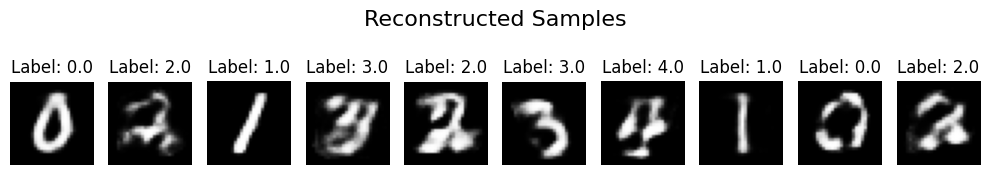

/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/436987700.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mod

num_epochs:  20
Training started...
Epoch [1/20], Loss: 1.3846, Accuracy: 68.20%
Test Accuracy: 94.34%
Test Accuracy: 94.69%
Epoch [2/20], Loss: 0.1168, Accuracy: 97.02%
Test Accuracy: 97.22%
Test Accuracy: 97.35%
Epoch [3/20], Loss: 0.0668, Accuracy: 98.34%
Test Accuracy: 96.31%
Test Accuracy: 96.69%
Epoch [4/20], Loss: 0.0467, Accuracy: 98.91%
Test Accuracy: 97.92%
Test Accuracy: 97.73%
Epoch [5/20], Loss: 0.0406, Accuracy: 99.10%
Test Accuracy: 97.35%
Test Accuracy: 97.42%
Epoch [6/20], Loss: 0.0313, Accuracy: 99.33%
Test Accuracy: 97.28%
Test Accuracy: 97.48%
Epoch [7/20], Loss: 0.0313, Accuracy: 99.37%
Test Accuracy: 97.28%
Test Accuracy: 97.31%
Epoch [8/20], Loss: 0.0212, Accuracy: 99.61%
Test Accuracy: 96.11%
Test Accuracy: 96.58%
Epoch [9/20], Loss: 0.0205, Accuracy: 99.67%
Test Accuracy: 97.08%
Test Accuracy: 97.28%
Epoch [10/20], Loss: 0.0187, Accuracy: 99.71%
Test Accuracy: 97.35%
Test Accuracy: 97.45%
Epoch [11/20], Loss: 0.0216, Accuracy: 99.64%
Test Accuracy: 96.27%
Test 

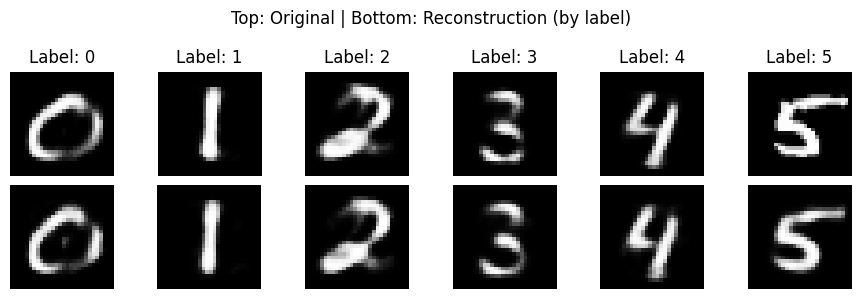

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


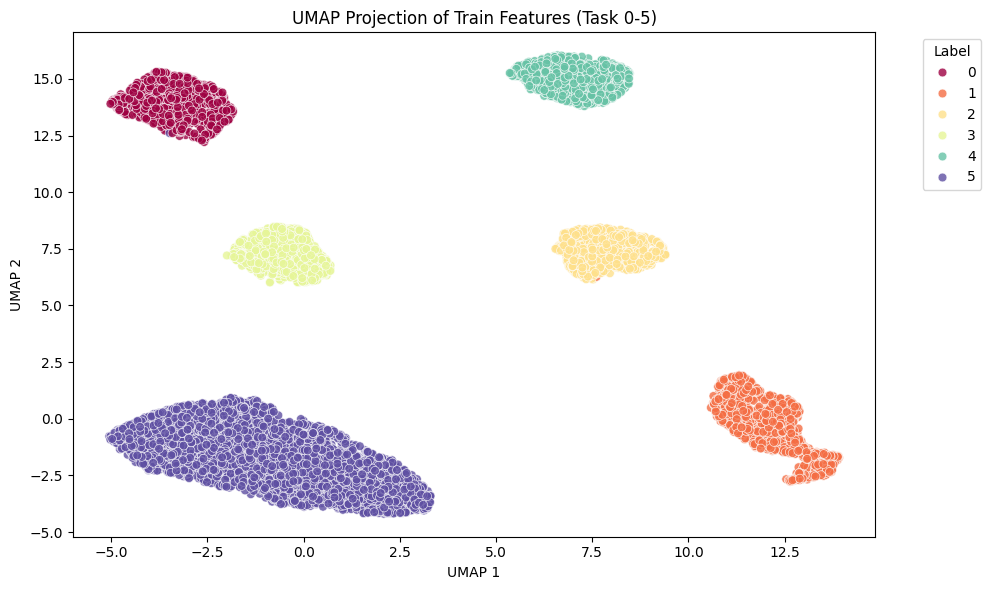

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


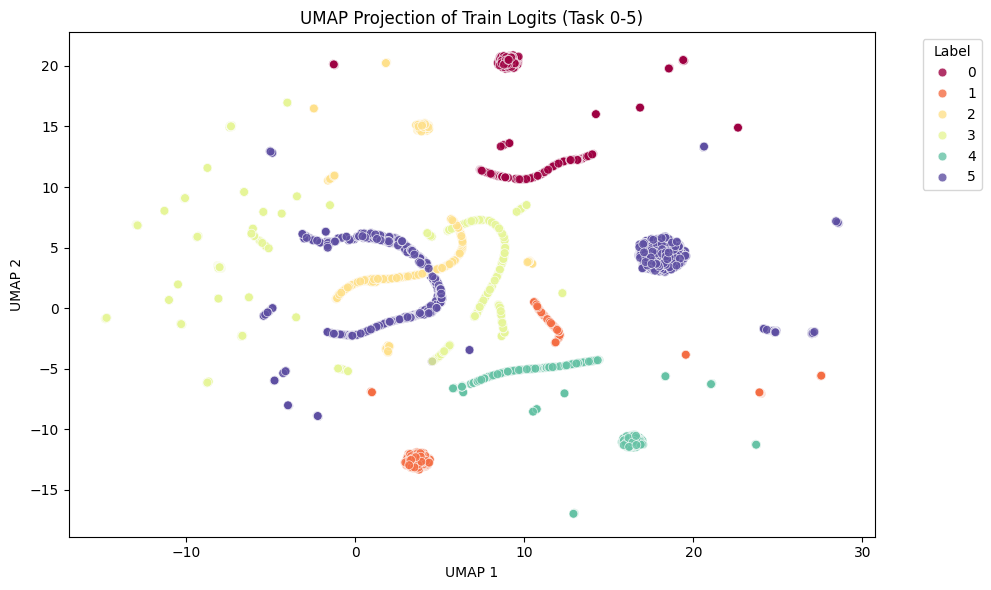

[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-5/out/f64_task0-5/train_sftmx.csv
[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-5/out/f64_task0-5/test_sftmx.csv

[INFO] END


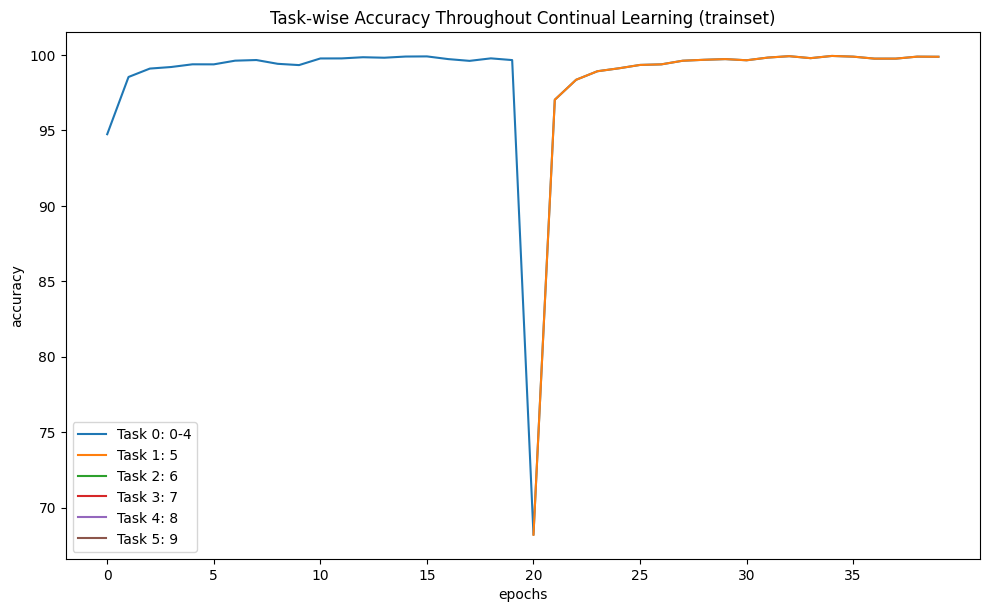

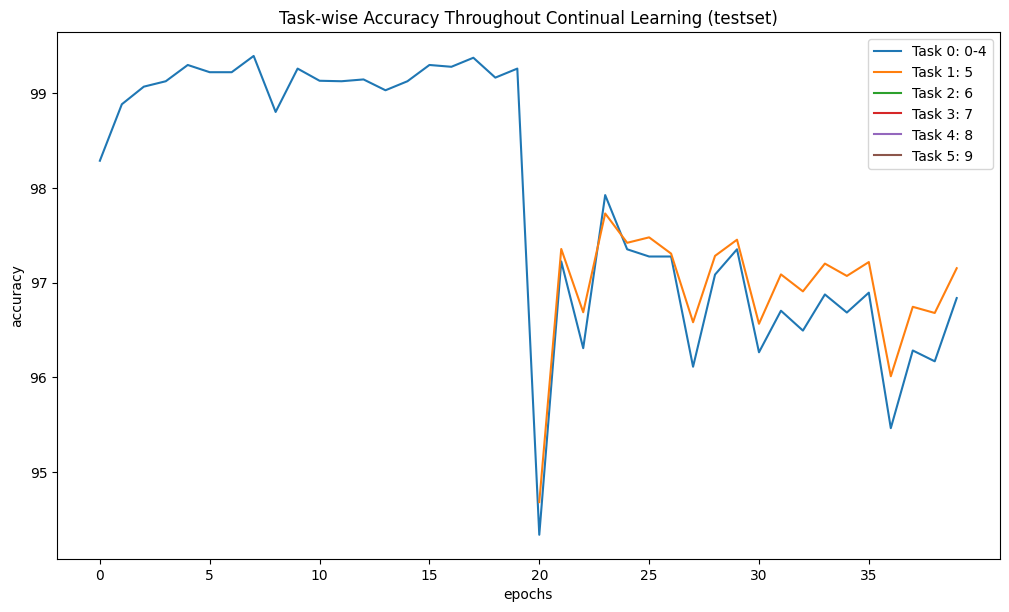

Class 0 size: 1500
  -> mean=0.23194, lower=0.23195, upper=0.23197
  -> kept: 1425 rows
Class 1 size: 1500
  -> mean=0.23195, lower=0.23197, upper=0.23197
  -> kept: 1425 rows
Class 2 size: 1500
  -> mean=0.22990, lower=0.22906, upper=0.23197
  -> kept: 1425 rows
Class 3 size: 1500
  -> mean=0.23192, lower=0.23183, upper=0.23197
  -> kept: 1425 rows
Class 4 size: 1500
  -> mean=0.23195, lower=0.23195, upper=0.23197
  -> kept: 1425 rows
Class 5 size: 5421
  -> mean=0.23167, lower=0.23193, upper=0.23197
  -> kept: 5150 rows
Class 6 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 7 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 8 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 9 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Filtered Training Data
Open task dir:  /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-5


Loading required package: Matrix

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is gplite version 0.13.0


Directory created successfully: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-5/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64 
[1] "Using original Y values (no log-space transform)"
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 0 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class0: 0.314928901516803"
[1] 1000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 1 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class1: 0.17976357170013"
[1] 2000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] 

Warning messages:
1: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
2: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
3: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
4: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
5: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
6: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 


[1] "Save Results"
null device 
          1 


In [64]:
run_task_i(task_id=1, task='0-5', prev_task='0-4', epochs=20)

# Task 2

[INFO] Running Task 2 with digits: 0-6
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-6/out/f64_task0-6
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-6/model/f64_task0-6
Loading previous model from: AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-5/model/f64_task0-5/MNIST_f64_task_0-5_net.pt
[INFO] Generated points saved to task0-5/indcpts_generated_points.csv
[INFO] Loaded indcpts from task0-5/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64/inducing_points.csv, shape: (6000, 65)
[INFO] Loaded generated points from task0-5/indcpts_generated_points.csv, shape: (3000, 65)
[INFO] Combined indcpts shape: (9000, 64), labels shape: (9000,)


/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/3566132364.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mo

[INFO] Reconstructed indcpts shape: (9000, 785)
[INFO] Reconstructed indcpts saved to task0-5/indcpts_reconstructions.csv
[INFO] Loaded 5918 training samples for digit 6


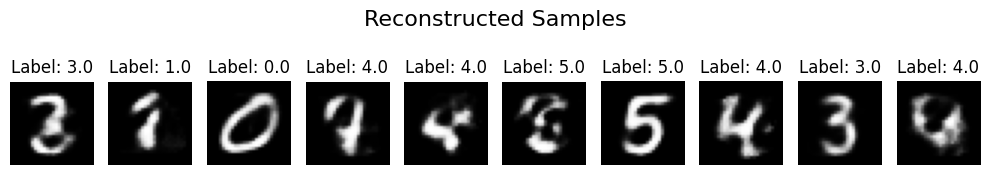

/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/436987700.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mod

num_epochs:  20
Training started...
Epoch [1/20], Loss: 1.3505, Accuracy: 73.62%
Test Accuracy: 95.12%
Test Accuracy: 95.16%
Test Accuracy: 95.40%
Epoch [2/20], Loss: 0.0893, Accuracy: 97.77%
Test Accuracy: 95.26%
Test Accuracy: 95.47%
Test Accuracy: 95.92%
Epoch [3/20], Loss: 0.0570, Accuracy: 98.50%
Test Accuracy: 95.64%
Test Accuracy: 95.65%
Test Accuracy: 96.14%
Epoch [4/20], Loss: 0.0442, Accuracy: 98.99%
Test Accuracy: 94.95%
Test Accuracy: 95.16%
Test Accuracy: 95.70%
Epoch [5/20], Loss: 0.0365, Accuracy: 99.10%
Test Accuracy: 95.52%
Test Accuracy: 95.46%
Test Accuracy: 95.88%
Epoch [6/20], Loss: 0.0296, Accuracy: 99.29%
Test Accuracy: 94.75%
Test Accuracy: 94.99%
Test Accuracy: 95.57%
Epoch [7/20], Loss: 0.0245, Accuracy: 99.46%
Test Accuracy: 95.89%
Test Accuracy: 95.95%
Test Accuracy: 96.32%
Epoch [8/20], Loss: 0.0215, Accuracy: 99.53%
Test Accuracy: 95.60%
Test Accuracy: 95.70%
Test Accuracy: 96.10%
Epoch [9/20], Loss: 0.0212, Accuracy: 99.52%
Test Accuracy: 94.61%
Test Accu

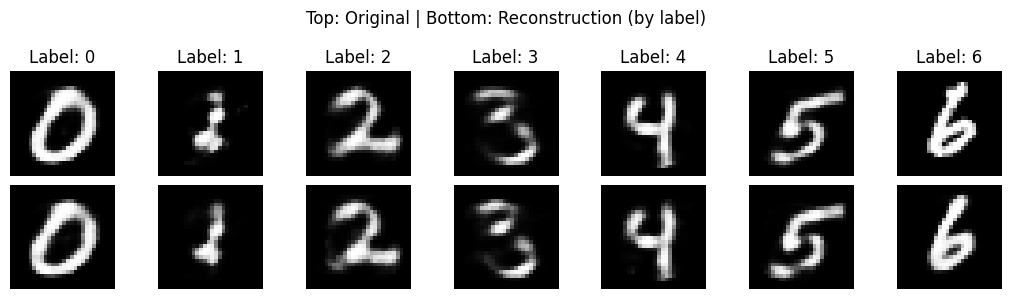

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


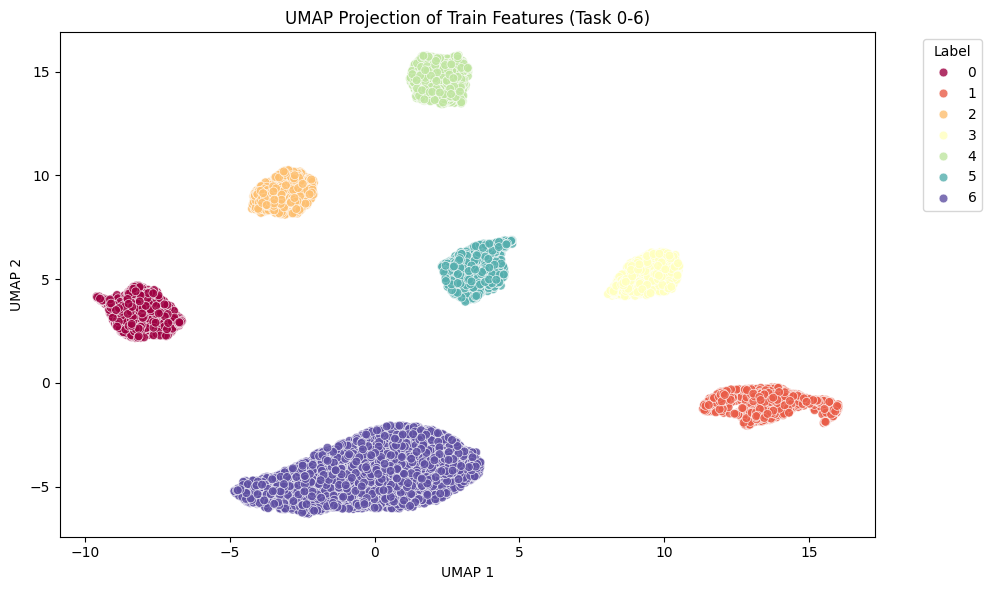

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


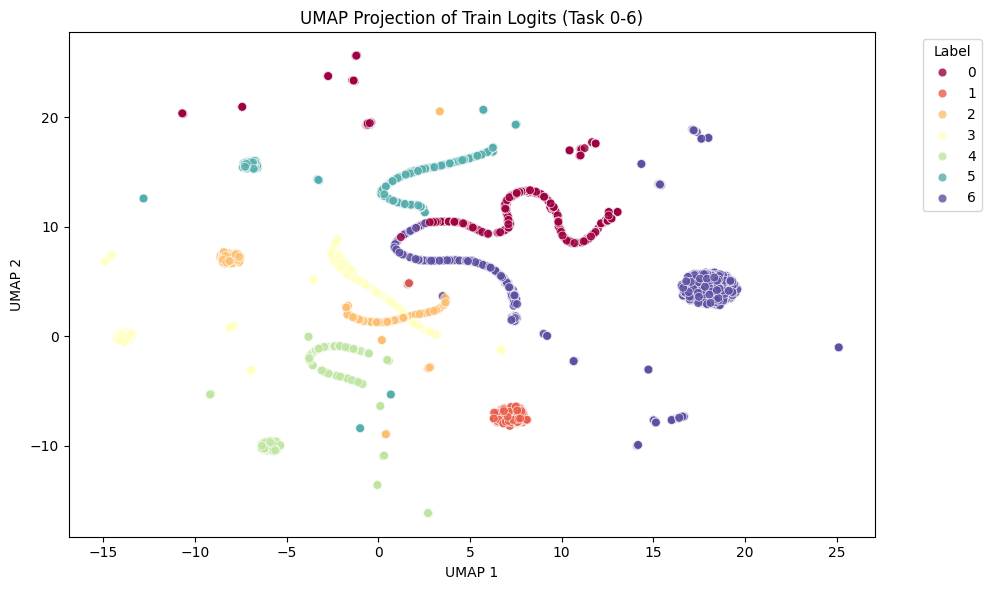

[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-6/out/f64_task0-6/train_sftmx.csv
[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-6/out/f64_task0-6/test_sftmx.csv

[INFO] END


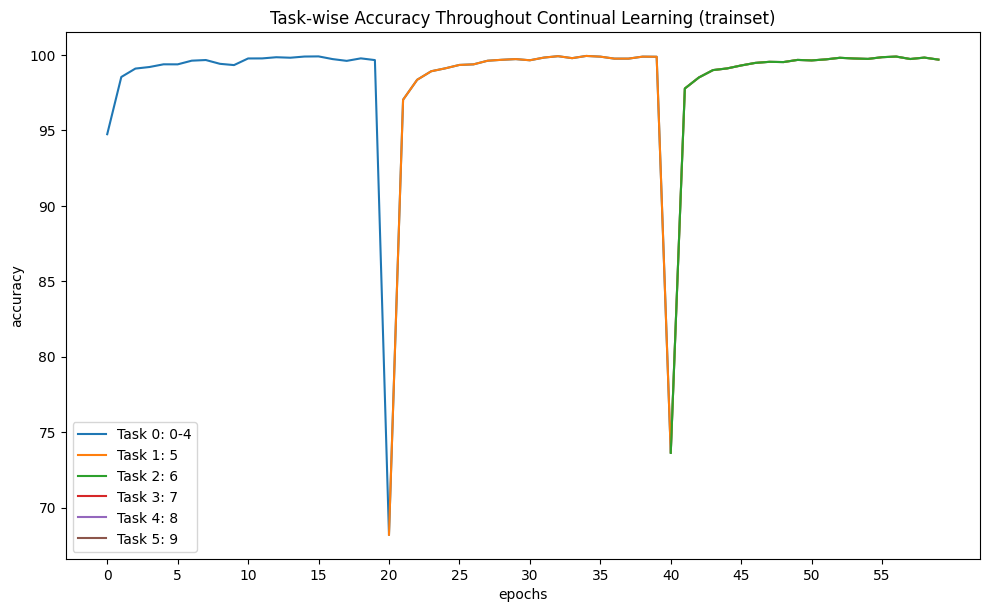

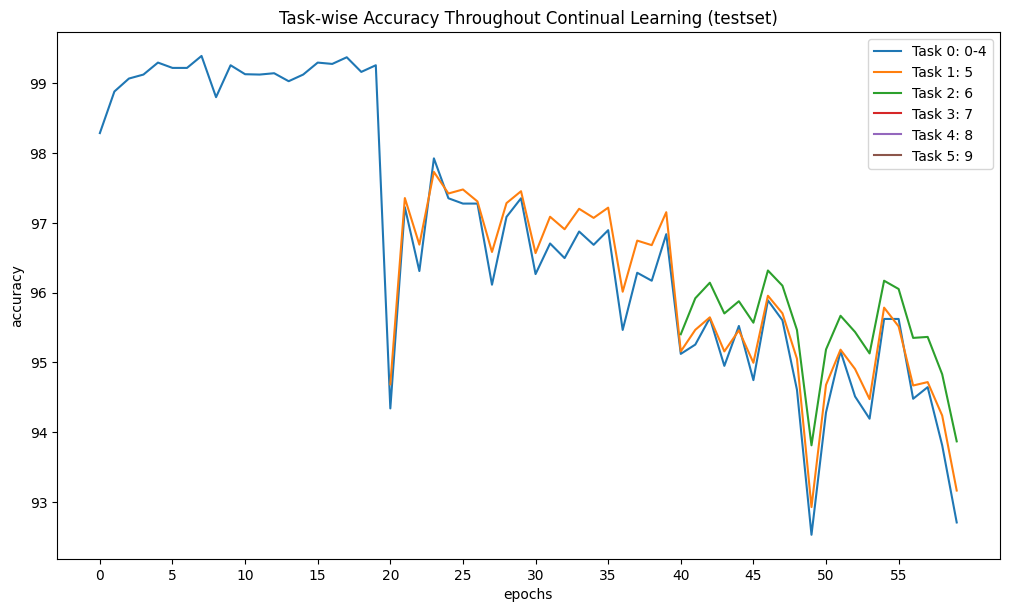

Class 0 size: 1500
  -> mean=0.22678, lower=0.21024, upper=0.23197
  -> kept: 1425 rows
Class 1 size: 1500
  -> mean=0.23197, lower=0.23197, upper=0.23197
  -> kept: 1464 rows
Class 2 size: 1500
  -> mean=0.23166, lower=0.23173, upper=0.23197
  -> kept: 1425 rows
Class 3 size: 1500
  -> mean=0.23170, lower=0.23187, upper=0.23197
  -> kept: 1425 rows
Class 4 size: 1500
  -> mean=0.23189, lower=0.23193, upper=0.23197
  -> kept: 1425 rows
Class 5 size: 1500
  -> mean=0.23131, lower=0.23155, upper=0.23197
  -> kept: 1425 rows
Class 6 size: 5918
  -> mean=0.23172, lower=0.23196, upper=0.23197
  -> kept: 5622 rows
Class 7 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 8 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 9 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Filtered Training Data
Open task dir:  /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-6


Loading required package: Matrix

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is gplite version 0.13.0


Directory created successfully: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-6/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64 
[1] "Using original Y values (no log-space transform)"
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 0 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class0: 0.168783091915714"
[1] 1000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1171"
[1] "n is greater than the number of rows in the data frame, using all rows:293"
[1] "class 1 training sample size (indclude n_octr other classes): 1221"
[1] "Using laGP package for training"
[1] "validation MSE for class1: 0.226972532034645"
[1] 2000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1]

Warning messages:
1: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
2: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
3: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
4: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
5: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
6: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
7: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 


[1] "Save Results"
null device 
          1 


In [65]:
run_task_i(task_id=2, task='0-6', prev_task='0-5', epochs=20)

# Task 3

[INFO] Running Task 3 with digits: 0-7
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-7/out/f64_task0-7
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-7/model/f64_task0-7
Loading previous model from: AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-6/model/f64_task0-6/MNIST_f64_task_0-6_net.pt
[INFO] Generated points saved to task0-6/indcpts_generated_points.csv
[INFO] Loaded indcpts from task0-6/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64/inducing_points.csv, shape: (7000, 65)
[INFO] Loaded generated points from task0-6/indcpts_generated_points.csv, shape: (3500, 65)
[INFO] Combined indcpts shape: (10500, 64), labels shape: (10500,)


/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/3566132364.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mo

[INFO] Reconstructed indcpts shape: (10500, 785)
[INFO] Reconstructed indcpts saved to task0-6/indcpts_reconstructions.csv
[INFO] Loaded 6265 training samples for digit 7


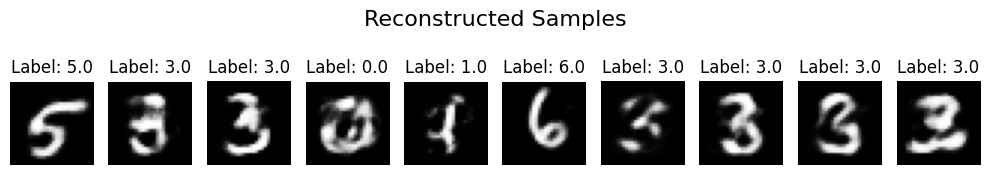

/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/436987700.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mod

num_epochs:  20
Training started...
Epoch [1/20], Loss: 1.4608, Accuracy: 72.95%
Test Accuracy: 93.20%
Test Accuracy: 93.24%
Test Accuracy: 93.92%
Test Accuracy: 94.29%
Epoch [2/20], Loss: 0.1154, Accuracy: 97.03%
Test Accuracy: 93.73%
Test Accuracy: 93.59%
Test Accuracy: 94.24%
Test Accuracy: 94.69%
Epoch [3/20], Loss: 0.0731, Accuracy: 98.06%
Test Accuracy: 93.94%
Test Accuracy: 93.77%
Test Accuracy: 94.39%
Test Accuracy: 94.88%
Epoch [4/20], Loss: 0.0558, Accuracy: 98.57%
Test Accuracy: 93.53%
Test Accuracy: 93.74%
Test Accuracy: 94.29%
Test Accuracy: 94.83%
Epoch [5/20], Loss: 0.0429, Accuracy: 98.93%
Test Accuracy: 93.98%
Test Accuracy: 94.03%
Test Accuracy: 94.56%
Test Accuracy: 95.06%
Epoch [6/20], Loss: 0.0324, Accuracy: 99.24%
Test Accuracy: 92.87%
Test Accuracy: 93.17%
Test Accuracy: 93.84%
Test Accuracy: 94.48%
Epoch [7/20], Loss: 0.0293, Accuracy: 99.33%
Test Accuracy: 92.43%
Test Accuracy: 92.30%
Test Accuracy: 93.18%
Test Accuracy: 93.88%
Epoch [8/20], Loss: 0.0241, Accur

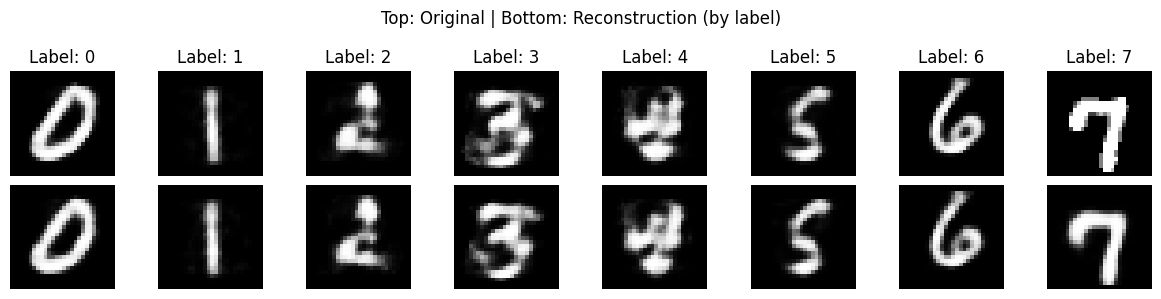

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


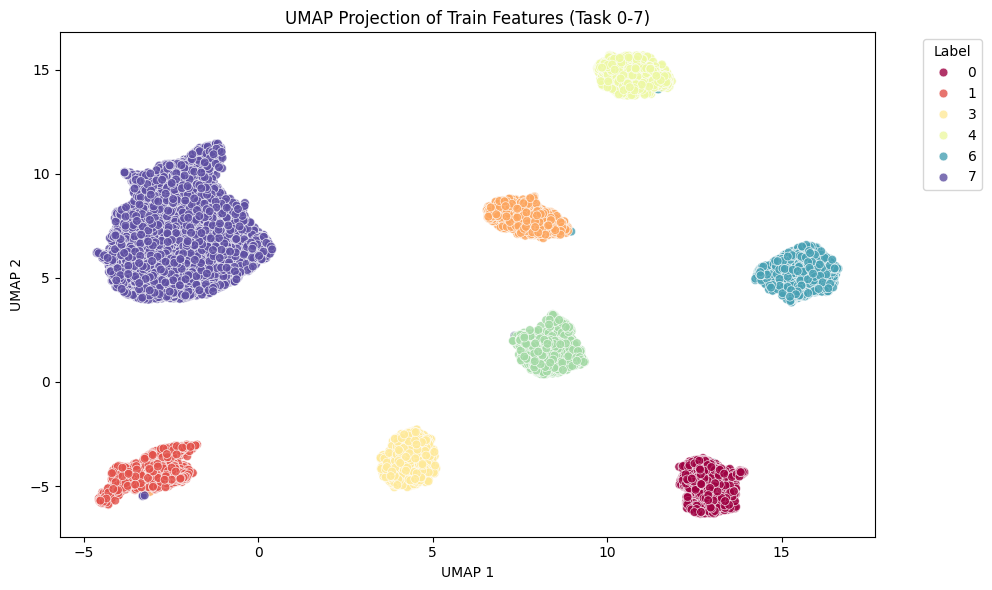

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


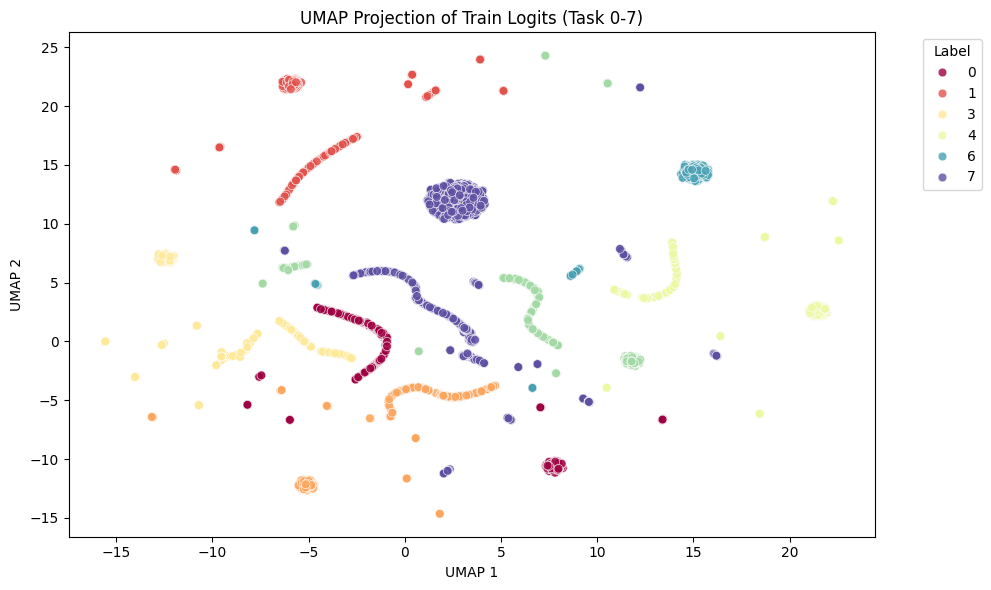

[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-7/out/f64_task0-7/train_sftmx.csv
[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-7/out/f64_task0-7/test_sftmx.csv

[INFO] END


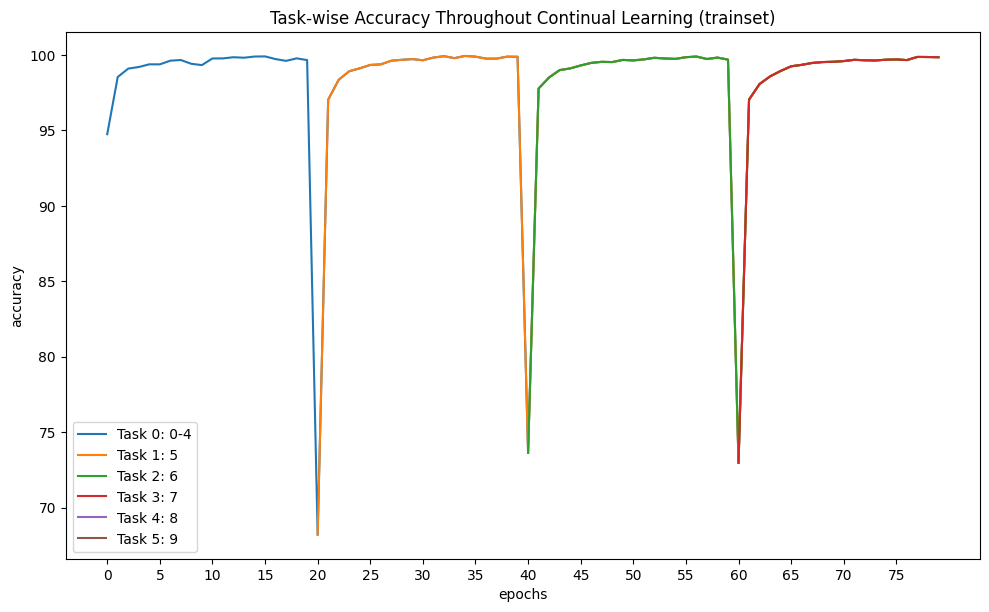

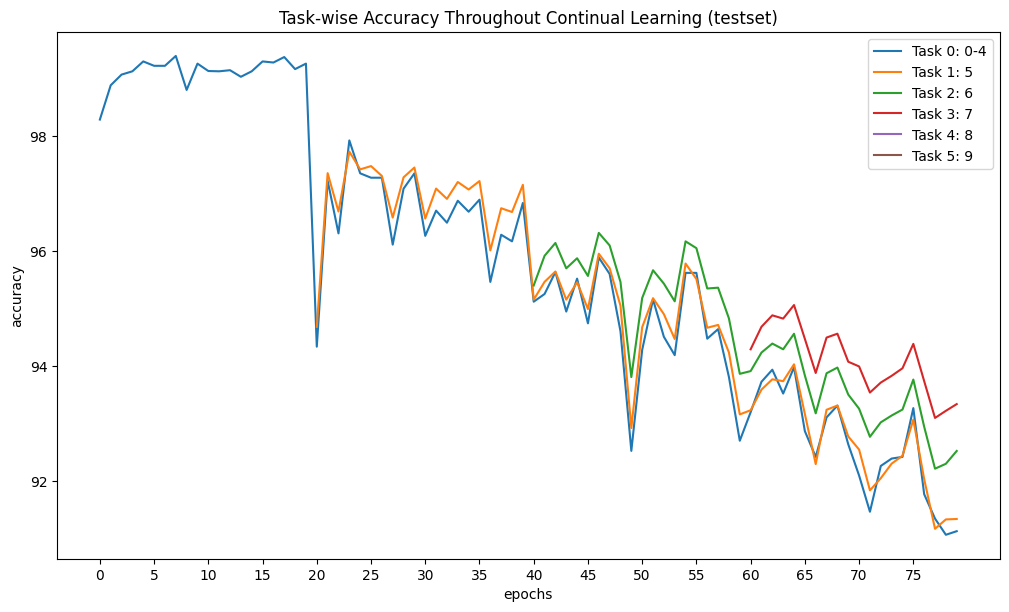

Class 0 size: 1500
  -> mean=0.23106, lower=0.23144, upper=0.23197
  -> kept: 1425 rows
Class 1 size: 1500
  -> mean=0.23183, lower=0.23190, upper=0.23197
  -> kept: 1425 rows
Class 2 size: 1500
  -> mean=0.23118, lower=0.23155, upper=0.23197
  -> kept: 1425 rows
Class 3 size: 1500
  -> mean=0.23190, lower=0.23194, upper=0.23197
  -> kept: 1425 rows
Class 4 size: 1500
  -> mean=0.23194, lower=0.23195, upper=0.23197
  -> kept: 1426 rows
Class 5 size: 1500
  -> mean=0.23171, lower=0.23171, upper=0.23197
  -> kept: 1425 rows
Class 6 size: 1500
  -> mean=0.23194, lower=0.23197, upper=0.23197
  -> kept: 1429 rows
Class 7 size: 6265
  -> mean=0.23190, lower=0.23196, upper=0.23197
  -> kept: 5951 rows
Class 8 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Class 9 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Filtered Training Data
Open task dir:  /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-7


Loading required package: Matrix

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is gplite version 0.13.0


Directory created successfully: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-7/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64 
[1] "Using original Y values (no log-space transform)"
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 0 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class0: 0.253235452189802"
[1] 1000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 1 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class1: 0.18301312605787"
[1] 2000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] 

Warning messages:
1: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
2: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
3: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
4: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
5: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
6: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
7: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
8: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 


[1] "Save Results"
null device 
          1 


In [66]:
run_task_i(task_id=3, task='0-7', prev_task='0-6', epochs=20)

# Task 4

[INFO] Running Task 4 with digits: 0-8
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-8/out/f64_task0-8
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-8/model/f64_task0-8
Loading previous model from: AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-7/model/f64_task0-7/MNIST_f64_task_0-7_net.pt
[INFO] Generated points saved to task0-7/indcpts_generated_points.csv
[INFO] Loaded indcpts from task0-7/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64/inducing_points.csv, shape: (8000, 65)
[INFO] Loaded generated points from task0-7/indcpts_generated_points.csv, shape: (4000, 65)
[INFO] Combined indcpts shape: (12000, 64), labels shape: (12000,)


/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/3566132364.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mo

[INFO] Reconstructed indcpts shape: (12000, 785)
[INFO] Reconstructed indcpts saved to task0-7/indcpts_reconstructions.csv
[INFO] Loaded 5851 training samples for digit 8


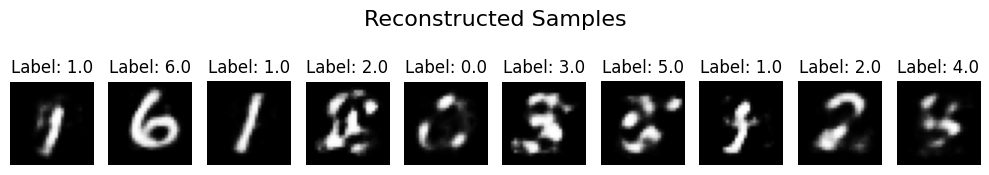

/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/436987700.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mod

num_epochs:  20
Training started...
Epoch [1/20], Loss: 1.3797, Accuracy: 64.55%
Test Accuracy: 91.91%
Test Accuracy: 91.48%
Test Accuracy: 92.31%
Test Accuracy: 92.99%
Test Accuracy: 82.95%
Epoch [2/20], Loss: 0.4609, Accuracy: 83.85%
Test Accuracy: 89.01%
Test Accuracy: 88.91%
Test Accuracy: 89.73%
Test Accuracy: 90.40%
Test Accuracy: 91.02%
Epoch [3/20], Loss: 0.1846, Accuracy: 94.14%
Test Accuracy: 86.62%
Test Accuracy: 86.51%
Test Accuracy: 87.94%
Test Accuracy: 88.92%
Test Accuracy: 89.79%
Epoch [4/20], Loss: 0.0889, Accuracy: 97.68%
Test Accuracy: 87.42%
Test Accuracy: 87.20%
Test Accuracy: 88.53%
Test Accuracy: 89.67%
Test Accuracy: 90.54%
Epoch [5/20], Loss: 0.0693, Accuracy: 98.23%
Test Accuracy: 88.63%
Test Accuracy: 88.26%
Test Accuracy: 89.43%
Test Accuracy: 90.37%
Test Accuracy: 91.11%
Epoch [6/20], Loss: 0.0537, Accuracy: 98.65%
Test Accuracy: 86.23%
Test Accuracy: 85.80%
Test Accuracy: 86.88%
Test Accuracy: 88.23%
Test Accuracy: 89.35%
Epoch [7/20], Loss: 0.0470, Accura

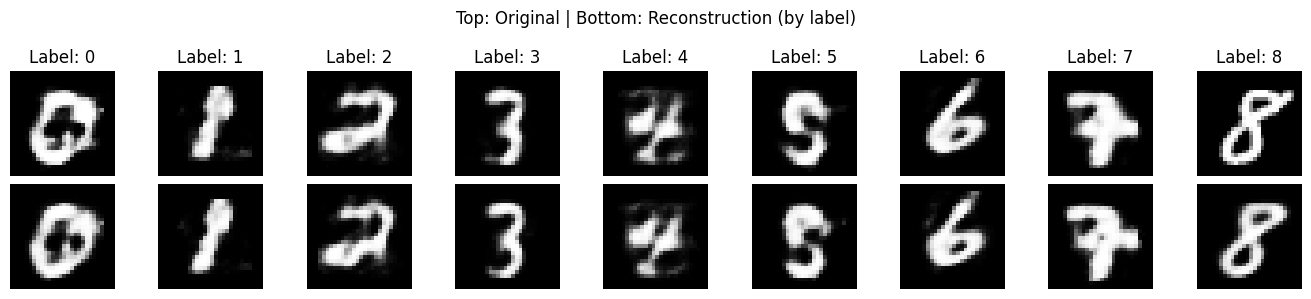

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


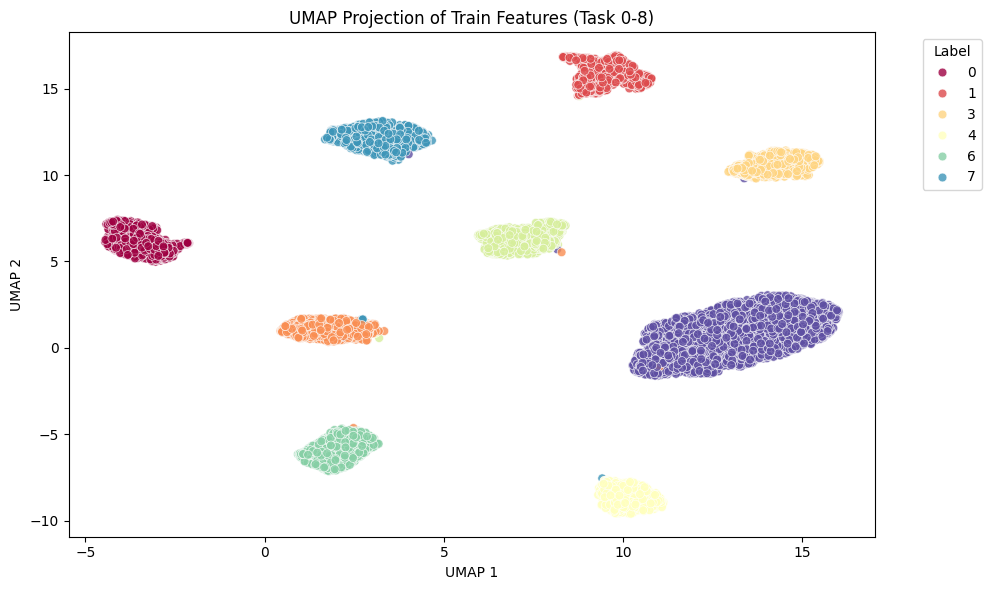

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


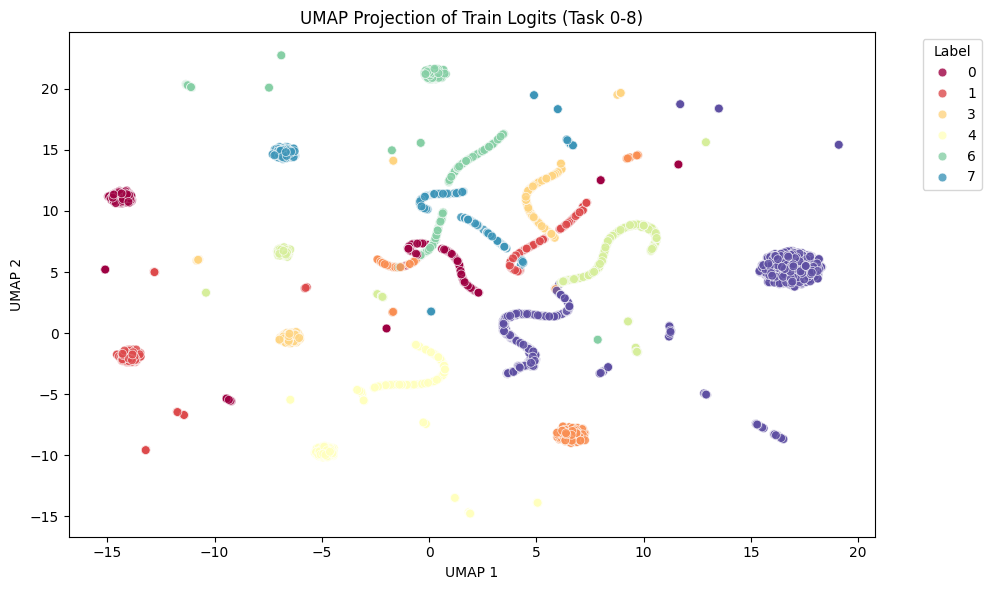

[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-8/out/f64_task0-8/train_sftmx.csv
[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-8/out/f64_task0-8/test_sftmx.csv

[INFO] END


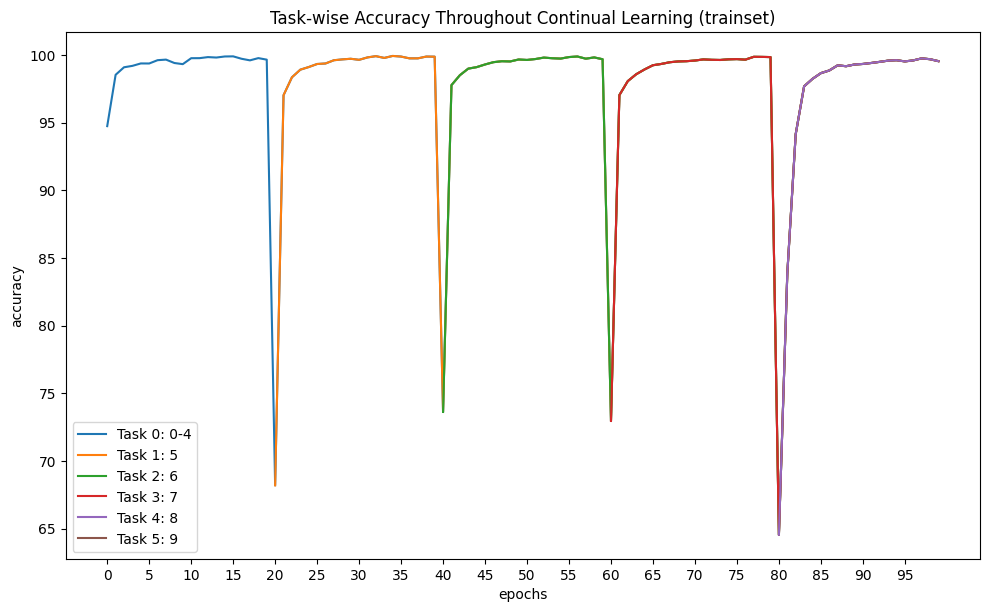

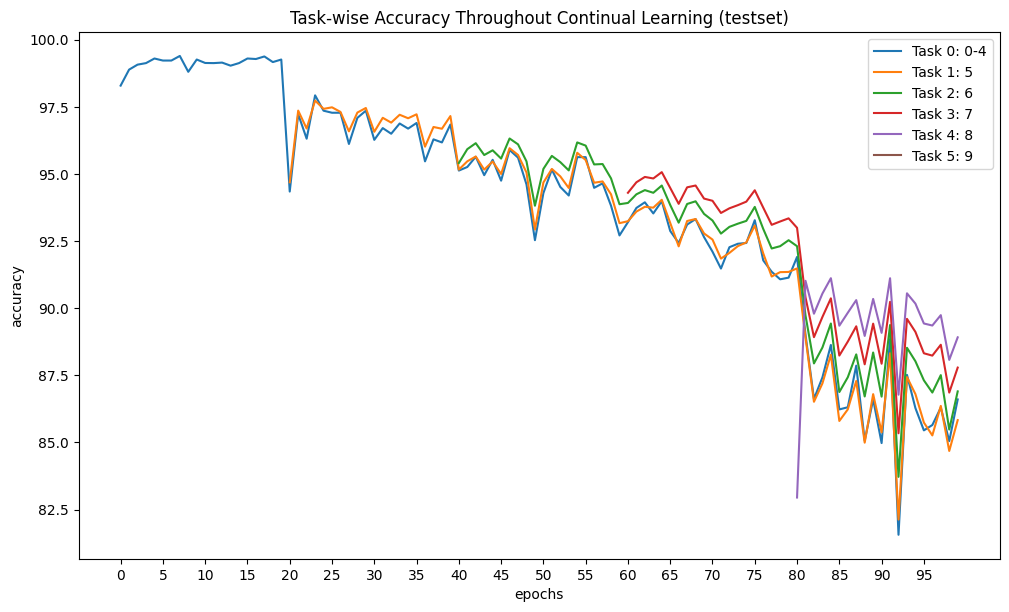

Class 0 size: 1500
  -> mean=0.23094, lower=0.23178, upper=0.23197
  -> kept: 1425 rows
Class 1 size: 1500
  -> mean=0.23193, lower=0.23196, upper=0.23197
  -> kept: 1425 rows
Class 2 size: 1500
  -> mean=0.23185, lower=0.23197, upper=0.23197
  -> kept: 1426 rows
Class 3 size: 1500
  -> mean=0.23156, lower=0.23186, upper=0.23197
  -> kept: 1425 rows
Class 4 size: 1500
  -> mean=0.23190, lower=0.23193, upper=0.23197
  -> kept: 1425 rows
Class 5 size: 1500
  -> mean=0.23089, lower=0.23135, upper=0.23197
  -> kept: 1425 rows
Class 6 size: 1500
  -> mean=0.22896, lower=0.22608, upper=0.23197
  -> kept: 1425 rows
Class 7 size: 1500
  -> mean=0.23043, lower=0.23167, upper=0.23197
  -> kept: 1425 rows
Class 8 size: 5851
  -> mean=0.23177, lower=0.23196, upper=0.23197
  -> kept: 5558 rows
Class 9 size: 0
  -> mean=nan, lower=nan, upper=nan
  -> kept: 0 rows
Filtered Training Data
Open task dir:  /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0

Loading required package: Matrix

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is gplite version 0.13.0


Directory created successfully: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-8/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64 
[1] "Using original Y values (no log-space transform)"
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 0 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class0: 0.272340287296543"
[1] 1000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 1 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class1: 0.28279892016127"
[1] 2000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] 

Warning messages:
1: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
2: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
3: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
4: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
5: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
6: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
7: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
8: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 


[1] "Save Results"
null device 
          1 


In [67]:
run_task_i(task_id=4, task='0-8', prev_task='0-7', epochs=20)

# Task 5

[INFO] Running Task 5 with digits: 0-9
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-9/out/f64_task0-9
[INFO] Created directory: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-9/model/f64_task0-9
Loading previous model from: AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-8/model/f64_task0-8/MNIST_f64_task_0-8_net.pt
[INFO] Generated points saved to task0-8/indcpts_generated_points.csv
[INFO] Loaded indcpts from task0-8/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64/inducing_points.csv, shape: (9000, 65)
[INFO] Loaded generated points from task0-8/indcpts_generated_points.csv, shape: (4500, 65)
[INFO] Combined indcpts shape: (13500, 64), labels shape: (13500,)


/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/3566132364.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mo

[INFO] Reconstructed indcpts shape: (13500, 785)
[INFO] Reconstructed indcpts saved to task0-8/indcpts_reconstructions.csv
[INFO] Loaded 5949 training samples for digit 9


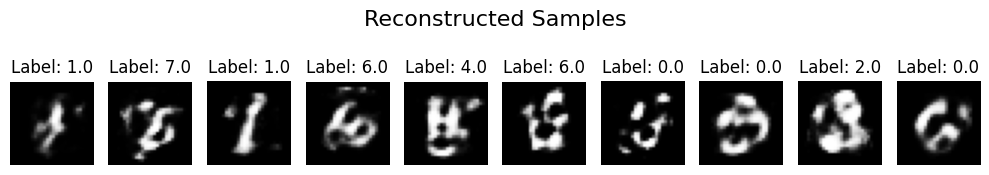

/var/folders/79/t4ghgh4x7hb3gnf8q5qvr0lc0000gn/T/ipykernel_94209/436987700.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_mod

num_epochs:  20
Training started...
Epoch [1/20], Loss: 1.3556, Accuracy: 65.45%
Test Accuracy: 85.27%
Test Accuracy: 84.72%
Test Accuracy: 86.27%
Test Accuracy: 87.31%
Test Accuracy: 88.43%
Test Accuracy: 79.57%
Epoch [2/20], Loss: 0.7564, Accuracy: 74.73%
Test Accuracy: 87.67%
Test Accuracy: 86.85%
Test Accuracy: 87.95%
Test Accuracy: 88.60%
Test Accuracy: 89.45%
Test Accuracy: 87.77%
Epoch [3/20], Loss: 0.3243, Accuracy: 93.34%
Test Accuracy: 84.14%
Test Accuracy: 83.76%
Test Accuracy: 85.21%
Test Accuracy: 85.54%
Test Accuracy: 86.53%
Test Accuracy: 87.76%
Epoch [4/20], Loss: 0.1291, Accuracy: 97.18%
Test Accuracy: 83.99%
Test Accuracy: 83.68%
Test Accuracy: 85.12%
Test Accuracy: 85.47%
Test Accuracy: 86.58%
Test Accuracy: 87.82%
Epoch [5/20], Loss: 0.1003, Accuracy: 97.54%
Test Accuracy: 83.91%
Test Accuracy: 83.23%
Test Accuracy: 84.88%
Test Accuracy: 85.15%
Test Accuracy: 86.18%
Test Accuracy: 87.56%
Epoch [6/20], Loss: 0.0761, Accuracy: 98.13%
Test Accuracy: 82.13%
Test Accurac

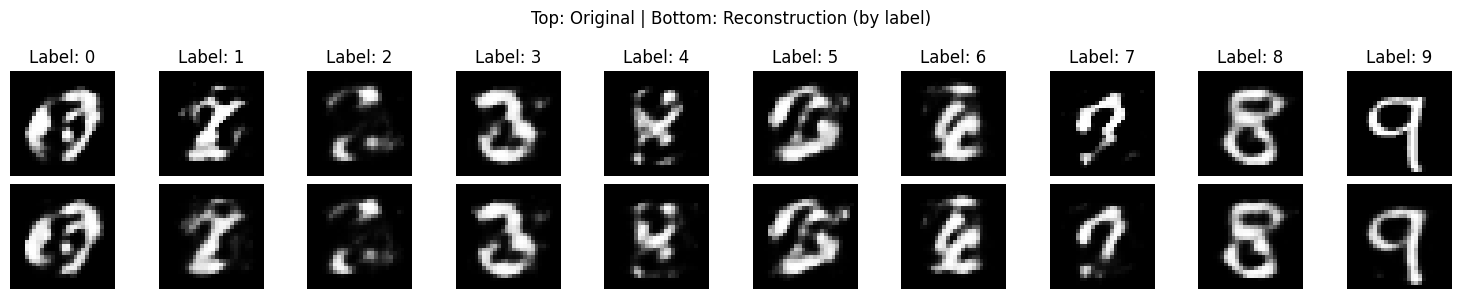

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


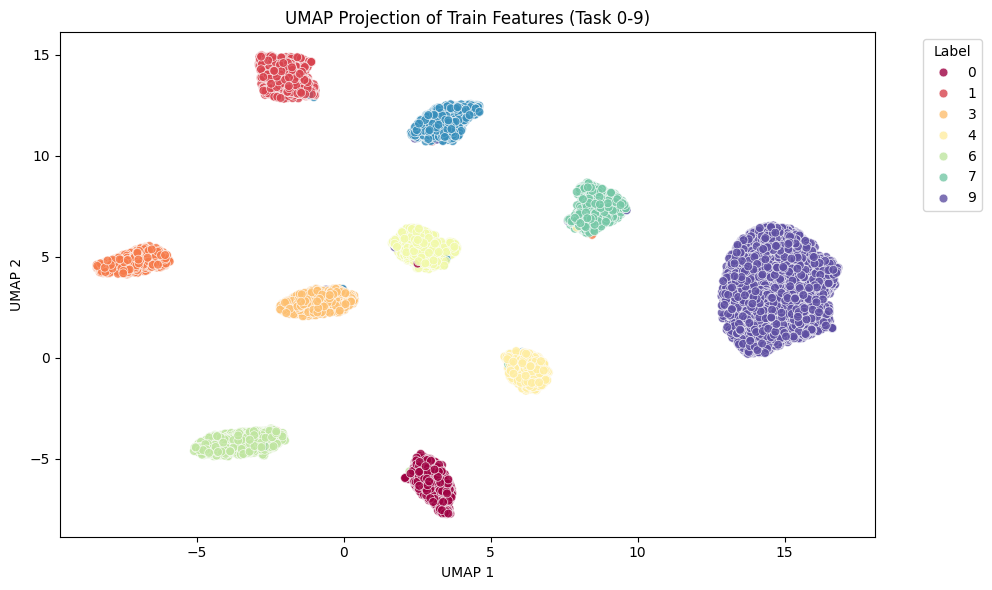

/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/hanliu/miniconda3/envs/lab/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


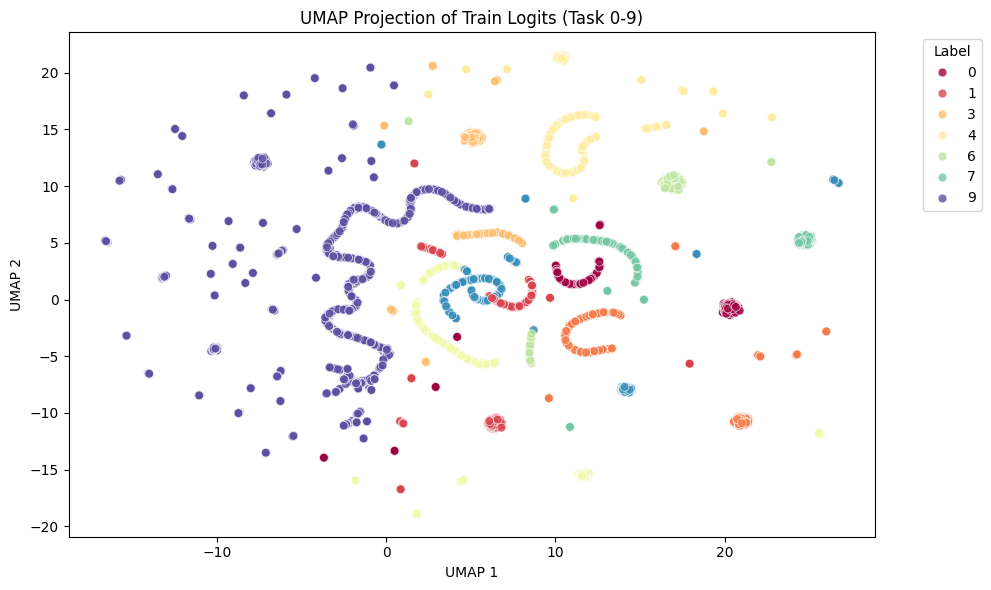

[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-9/out/f64_task0-9/train_sftmx.csv
[INFO] Data saved to /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-9/out/f64_task0-9/test_sftmx.csv

[INFO] END


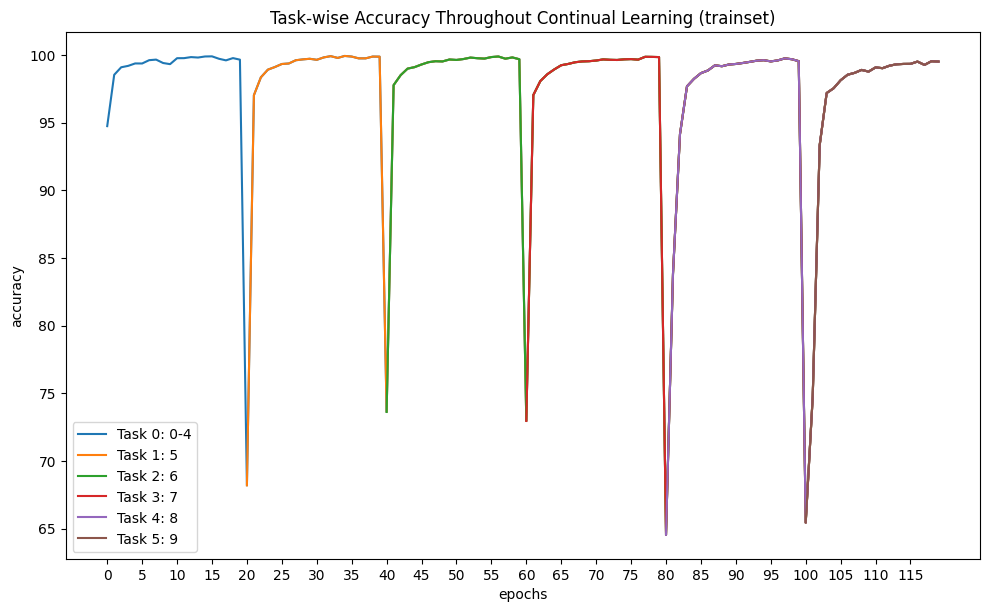

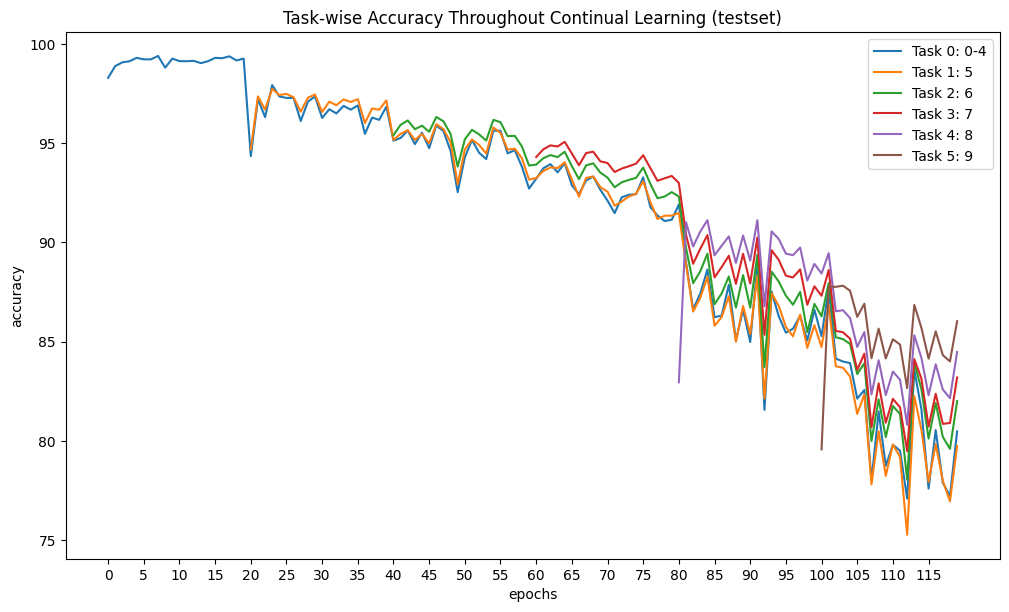

Class 0 size: 1500
  -> mean=0.23148, lower=0.23189, upper=0.23197
  -> kept: 1425 rows
Class 1 size: 1500
  -> mean=0.23160, lower=0.23184, upper=0.23197
  -> kept: 1425 rows
Class 2 size: 1500
  -> mean=0.23138, lower=0.23173, upper=0.23197
  -> kept: 1425 rows
Class 3 size: 1500
  -> mean=0.23184, lower=0.23187, upper=0.23197
  -> kept: 1425 rows
Class 4 size: 1500
  -> mean=0.23095, lower=0.23110, upper=0.23197
  -> kept: 1425 rows
Class 5 size: 1500
  -> mean=0.23045, lower=0.23038, upper=0.23197
  -> kept: 1425 rows
Class 6 size: 1500
  -> mean=0.23186, lower=0.23197, upper=0.23197
  -> kept: 1425 rows
Class 7 size: 1500
  -> mean=0.23173, lower=0.23188, upper=0.23197
  -> kept: 1425 rows
Class 8 size: 1500
  -> mean=0.23131, lower=0.23093, upper=0.23197
  -> kept: 1425 rows
Class 9 size: 5949
  -> mean=0.23146, lower=0.23176, upper=0.23197
  -> kept: 5651 rows
Filtered Training Data
Open task dir:  /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_d

Loading required package: Matrix

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is gplite version 0.13.0


Directory created successfully: /Users/hanliu/Local/CALM_AE/AElaGP_tr1500ts1000octr50_indcpts1000_f64_genpts500_doubleSoftmax/task0-9/RData/indpts_Rdata_ntr1500_nts1000_noctr50_f64 
[1] "Using original Y values (no log-space transform)"
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 0 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class0: 0.301867774019418"
[1] 1000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1] "n is greater than the number of rows in the data frame, using all rows:285"
[1] "class 1 training sample size (indclude n_octr other classes): 1190"
[1] "Using laGP package for training"
[1] "validation MSE for class1: 0.302877294731671"
[1] 2000   64
[1] "n is greater than the number of rows in the data frame, using all rows:1140"
[1]

Warning messages:
1: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
2: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
3: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
4: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
5: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 
6: Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`). 


[1] "Save Results"
null device 
          1 


In [68]:
run_task_i(task_id=5, task='0-9', prev_task='0-8', epochs=20)